### Zoonotic Potential

- [*] remember to turn of EC2 instance


### Planning

- measure host abundance for each zoonotic SOTU
- measure host abundance for each non-zoonotic SOTU
- measure differential expression between positive and negative sets
- statistical test of differential AGS with FGS of zoonotic potential (Virus set enrichment analysis)


### Done

- [x] parse virus dataset
- [x] find number of genuses with differing in zoonotic values
- [x] find rank distribution of has_potential_host
    - total: 438167, species: 414190, genus: 24, family: 49
- [x] manually patch tax_ids for all species
- [x] find number of virus species with associated SOTU
    - match genus taxons via list
- [x] create projection of SOTUs and sequence alignments using zoonotic viruses
- [x] setup graphistry visualization
- [x] clustering analysis on SOTUs
    - [x] setup community detection with seeded taxId
    - [x] WCC
    - [x] Louvain and lieden
- [x] Include STAT hosts into projection 
- [x] understand discrepancy between zoonotic label and human host association
    - goal: may need to re-examine using dataset for FGS?
    - may be able to create our own zoonotic dataset using STAT?
    - create a functional gene set (FGS) using entirety of the network of viruses in humans? if there is strong agreement
- [x] update Graphistry with stat hosts (order level only)
- [x] decide on using community or individual virus order/species
    - find differentially expression of hosts (AGS) between positive and negative sets
    - compare with FGS from entire network with specific hosts?
- [x] sanity check clustering threshold at 80 - 90 %
    - Seq_alignment
        - max(r.percentIdentity): 0.951
        - avg(r.percentIdentity): 0.584658444611331
- [x] for each species find abundance of host taxons
    - [x] remap host abundance by class [mammals, fish, plants, fungii, parasite]
    - [x] find taxids for each
    - store in CSV/table with each species as a row (index), column for zoonotic potential, other columns as classes, 
- [x] issue:
    - sotu exists in sotu_nodes: u29006
    - sotu doesn't exist in has_host_order_stat edges
    - sotu should have edge: 548681
    - taxon exists in taxon nodes: 548681
- [x] Issue: x SOTUs have no associated host? could be related to threshold
    - seems to be related to metagenome samples with weak STAT associations
    - could consider ignoring unclassified sequence labels: 12908
    - kmerPercentFull is comparing kmers to total spots?
    - q: how does this impact hostClass distributions
- [x] statistics on STAT host range
    - compare variance within zoonotic and non-zoonotic
        - log intensity-ratio
    - compare differential change between zoonotic and non-zoonotic
        - check if using DSEQ2 works
        - rank-sum test 
        - https://nbisweden.github.io/excelerate-scRNAseq/session-de/session-de-methods.html
        - find pvals, Fold-change, log-of-the-fold-changes for each class of zoonotics
        - rank host range by significance and abundance (Sign(FC) \* -log_10(pvalue))
        - find significantly upregulated or down regulated traits to create functional class (gene set)
- [x] Investigate STAT vs zoonotic label:
    - check specific counts of zoonotic SOTUs with primate hosts
    - check specific counts of non-zoonotc with primate hosts
- [x] investigate STAT threshold:
    - vary threshold to use percentIdentity >= 0.2
    - what does it mean if zoonotic viruses are dependent on metagenome samples, namely upregulated in bacteria
    - why do SOTUs appear in sotu_nodes without and relationships?
- variational analysis:
    - [x] modify code to run all steps for different STAT threshold
    - [x] save data in folders
    - [x] create panel of plots:
        - Mammals and Bacteria (other classes as well)
        - vary STAT threshold
        - create scatter bar plots for z_0, z_1, z_t, z_r
    - [x] diversity by num unique tax orders
        - instead of aggregating by count, group by hostClass and count unique taxOrders 
    - [x] normalize host count by SRA run counts
    - [x] normalize host count by bioproject
- [x] Update GDS version
    - https://graphdatascience.ninja/versions.json
    - cur gds == 2.3.4, cur neo4j == 5.7.0
    - new gds == 2.5.2 
- 

### TODO

- Decide on analysis:
    - GSEA rank-based approach
    - Varying STAT vs varying SOTU similarity
- 

- Create graphistry visualization
    - use STAT @ 0.8
    - remove label for SOTUs, only have labels for taxons
    - color by taxon, isZoonotic, not zoonotic use orange from slides (#e46c0a, #f79646)
    - 
- 

- compare zoonotic label to STAT associations:
- 

- topological analysis:
    - [x] neo4j filtered node similarity comparing zoonotic to non-zoonotic
        - compute stats using intra-group: with node ids or label
        - compute stats using inter-group: with node ids or label
    - topological link prediction
        - compute scores of various topological link prediction between vertebrate animals to humans preferential_attachment
        - 
-

- use GSEA rank instead of DSeq2 (?)


- Repeat while using cluster with varying similarities

- Check Jaccard similarity when using host metadata label

- investigate metagenome samples:
    - coarser: use metagenomic label instead of STAT
    - granular: use taxOrder instead of hostClass
    - post in slack
    - [*] investigate hostClass labels:
        - Move to seperate query and dataframe, merge after (fix bug with duplicate rows)
        - Test: Add metagenomic class for unclassified tax_id based on metadata labe?
        - manually review other, bacteriam etc
-


- -[*] look into how to increase dataset coverage
    - check for genbank ids in SQL
    - Many SOTUs have no host, likely related to threshold on metagenome samples, thresholding on percentIdentity seems sufficent, 0.2
-

- for each {community, species} measure network topology metric of sotus and full trait hierachy
    - do I need to use a community of SOTUs?
    - Modularity, etc
    - spectrum

-  topological link prediction

- compute full overlap (jaccard similarity) of all pathogen interactions and STAT hosts?

- Decide on including tissues
    - get list of unique SRAs
    - [*] check overlap of SRA runs in SQL tissue table 
    - for each {community, species} find tissue abundance by class

- Add global biotic interaction data to graph
    - https://www.globalbioticinteractions.org/?interactionType=interactsWith&sourceTaxon=NCBI%3A11272
    - https://www.globalbioticinteractions.org/data#interaction-data-indexes
    - add isHumanPathogen value? or GLOBI_PATHOGEN_OF
    - can download all interactions as NEO4j graph db
    - deeper investigation of known pathogens, STAT host associations, Host metadata labels

In [32]:
# Imports and config for the zoonotic-potential notebook

## Notebook config
import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%reload_ext dotenv
%dotenv

import collections
import os
import urllib.parse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphistry
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats


from datasources.neo4j import gds
from queries import utils

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [33]:
# Configs

base_data_path = './zoonosis_data/'
virus_dataset = base_data_path + 'trefle/'
neo4j_data_path = base_data_path + 'neo4j/'
graphistry_data_path = base_data_path + 'graphistry/'
outputs = base_data_path + 'outputs/' 

graphistry.register(
    api=3,
    username=os.getenv('GRAPHISTRY_USERNAME'),
    password=os.getenv('GRAPHISTRY_PASSWORD'),
)

print(gds)


stat_thresholds = [0.2, 0.5, 0.8]

df = pd.read_csv(virus_dataset + 'viruses.csv')

### Fill in tax_ids (only run once)

In [3]:
unique_names = df['vVirusNameCorrected'].unique()

def parse_scientific_name(name):
    """
    Parse a scientific name into its components.
    """
    name = name.replace('_', ' ')
    return name

with open( virus_dataset + 'species_names.txt', 'w') as f:
    for line in unique_names:
        f.write(f"{parse_scientific_name(line)}\n")

In [55]:
cat ./zoonosis_data/trefle/species_names.txt | taxonkit name2taxid  >> ./zoonosis_data/trefle/species_taxids.tsv

In [56]:
df2 = pd.read_csv(virus_dataset + 'species_taxids.tsv', sep='\t', header=None, names=['name', 'taxid'])
print(df2.head())
print(df2.shape)
print(df2['taxid'].isna().sum())

                                name    taxid
0               Adelaide River virus  31612.0
1           Adeno-associated virus-1      NaN
2           Adeno-associated virus-2      NaN
3           Adeno-associated virus-5      NaN
4  African green monkey polyomavirus  12480.0
(586, 2)
269


### Form zoonotic dataset

In [34]:
# Manually fill in any unresolved taxids
df2 = pd.read_csv(virus_dataset + 'species_taxids_patched.tsv', sep='\t', header=None, names=['name', 'taxid'])
df2['name'] = df2['name'].str.replace(' ', '_')
missing_taxid = df2[df2['taxid'].isna()]['name']

print(missing_taxid.shape)

merged = pd.merge(df, df2, left_on='vVirusNameCorrected', right_on='name', how='left')
merged = merged.drop(columns=['name'])
merged = merged.rename(columns={'taxid': 'TaxID'})
merged_dropna = merged.dropna(subset=['TaxID'])
merged_dropna['TaxID'] = merged_dropna['TaxID'].astype(int)
merged_dropna['TaxID'] = merged_dropna['TaxID'].astype(str)

print(merged.shape)
print(merged_dropna.shape)
print()

print(merged_dropna['IsZoonotic'].value_counts())
print(merged_dropna['IsZoonotic.stringent'].value_counts())
print(merged_dropna['ReverseZoonoses'].value_counts())

(22,)
(586, 24)
(564, 24)

0    378
1    186
Name: IsZoonotic, dtype: int64
0    458
1    106
Name: IsZoonotic.stringent, dtype: int64
0    557
1      7
Name: ReverseZoonoses, dtype: int64


/var/folders/vl/wsxpm_412lgcfm03dqd31qmh0000gn/T/ipykernel_13440/3246926767.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_dropna['TaxID'] = merged_dropna['TaxID'].astype(int)
/var/folders/vl/wsxpm_412lgcfm03dqd31qmh0000gn/T/ipykernel_13440/3246926767.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_dropna['TaxID'] = merged_dropna['TaxID'].astype(str)


### Neo4j queries

#### Dataset Serratus overlap QA

Mapping tax_id to virus name:
- 586 virus in original dataset, 564 after parsing name to ncbi taxid, couldn't find 22 viruses in NCBI taxonomy. Of these 564, 378 are not zoonotic, 186 are zoonotic

Mapping SOTUs to virus tax_id 
- Direct query of virus taxons from the dataset to mapped SOTUs results in coverage of 181 virus taxons (383 have no direct SOTUs). From these 181 virus taxons, there are 742 SOTU associations, max 215, mean ~4, std ~17. All of the SOTUs potential tax labels have strong percent identity and palmrint coverage (>= .95), i didn't account for e-values.
- Including all children and any parents with 'species' level rank from the virus taxons in the dataset does not increase the number of mapped virus taxons or SOTUs. 

```
v1:
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (187, 7)
has_host_order_stat_edges:  (1346, 10)

v2 [threshold on STAT @ 0.2]:
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (281, 7)
has_host_order_stat_edges:  (2950, 10)

v3 [threshold on STAT @ 0.5]:
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (231, 7)
has_host_order_stat_edges:  (1642, 10)

v4 [threshold on STAT @ 0.9]
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (167, 7)
has_host_order_stat_edges:  (877, 10)
```

In [4]:
query_sotu_nodes = """
    MATCH (a:SOTU)-[:HAS_POTENTIAL_TAXON]->(b:Taxon)
    WHERE b.taxId in $tax_ids
    RETURN
        id(a) as nodeId,
        a.palmId as appId,
        a.palmId as palmId,
        labels(a) as labels,
        b.taxId as taxId,
        b.rank as taxRank,
        b.taxOrder as taxOrder,
        CASE WHEN b.taxId in $zoonotic_tax_ids THEN True ELSE False END AS isZoonotic
"""

query_sotu_msa_edges = """
    MATCH (a:SOTU)-[r:SEQUENCE_ALIGNMENT]->(b:SOTU)
    WHERE a.palmId in $sotus
    AND b.palmId in $sotus
    RETURN
        id(a) as sourceNodeId,
        a.palmId as sourceAppId,
        id(b) as targetNodeId,
        b.palmId as targetAppId,
        'SEQUENCE_ALIGNMENT' as relationshipType,
        r.percentIdentity as percentIdentity,
        r.percentIdentity as weight
"""

query_stat_taxon_order_nodes = """
    CALL {
        MATCH (p:SOTU)<-[:HAS_SOTU]-(:Palmprint)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[q:HAS_HOST_STAT]->()-[:HAS_PARENT*0..]->(t:Taxon {rank: 'order'})
        WHERE p.palmId in $sotus
        AND q.percentIdentity >= $stat_threshold
        OPTIONAL MATCH (t)-[:HAS_PARENT*0..]->(u:Taxon)
        WHERE u.taxId in $host_class_tax_ids
        RETURN t, u
        UNION
        MATCH (p:SOTU)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[q:HAS_HOST_STAT]->()-[:HAS_PARENT*0..]->(t:Taxon {rank: 'order'})
        WHERE p.palmId in $sotus
        AND q.percentIdentity >= $stat_threshold
        OPTIONAL MATCH (t)-[:HAS_PARENT*0..]->(u:Taxon)
        WHERE u.taxId in $host_class_tax_ids
        RETURN t, u
    }
    WITH t, u
    RETURN
        id(t) as nodeId,
        t.taxId as appId,
        t.taxId as taxId,
        labels(t) as labels,
        t.rank as taxRank,
        t.taxOrder as taxOrder,        
        CASE WHEN u.taxId = '40674' THEN 'Mammal' ELSE 
            CASE WHEN u.taxId = '33090' THEN 'Plant' ELSE 
                CASE WHEN u.taxId = '4751' THEN 'Fungi' ELSE 
                    CASE When u.taxId = '33630' THEN 'Parasite' ELSE 
                         CASE WHEN (u.taxId = '1476529' OR u.taxId = '7777' OR u.taxID = '1476750' OR u.taxId = '7742') THEN 'Fish-like' ELSE
                            CASE WHEN u.taxId = '10239' THEN 'Virus' ELSE 
                                CASE WHEN u.taxId = '6656' THEN 'Anthropod' ELSE 
                                    CASE WHEN u.taxId = '2' THEN 'Bacteria' ELSE
                                        'Other'
                                    END
                                END
                            END
                        END
                    END
                END
            END
        END AS hostClass
"""

query_has_host_order_stat = '''
    CALL {
        MATCH (p:SOTU)<-[:HAS_SOTU]-(:Palmprint)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[q:HAS_HOST_STAT]->()-[:HAS_PARENT*0..]->(t:Taxon {rank: 'order'})
        WHERE p.palmId in $sotus
        AND q.percentIdentity >= $stat_threshold
        RETURN p, t, r, q
        UNION
        MATCH (p:SOTU)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[q:HAS_HOST_STAT]->()-[:HAS_PARENT*0..]->(t:Taxon {rank: 'order'})
        WHERE p.palmId in $sotus
        AND q.percentIdentity >= $stat_threshold
        RETURN p, t, r, q
    }
    WITH p, t, r, q
    RETURN
        id(p) as sourceNodeId,
        p.palmId as sourceAppId,
        id(t) as targetNodeId,
        t.taxId as targetAppId,
        //CASE WHEN percentIdentityFull >= 0.2 THEN id(t) ELSE 8765758 END AS targetNodeId,
        //CASE WHEN percentIdentityFull >= 0.2 THEN t.taxId ELSE '12908' END AS targetAppId,
        'HAS_HOST_STAT' as relationshipType,
        count(*) AS count,
        avg(r.percentIdentity) as avgPercentIdentityPalmprint,
        avg(q.percentIdentity) as avgPercentIdentityStatKmers,
        avg(q.percentIdentityFull) as avgPercentIdentityStatSpots,
        avg(q.percentIdentity) * avg(r.percentIdentity) as weight
'''


query_has_host_metadata_label = """
    CALL {
        MATCH (p:SOTU)<-[:HAS_SOTU]-(:Palmprint)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[q:HAS_HOST]->(t:Taxon)
        WHERE p.palmId in $sotus
        RETURN p, t, r, q
        UNION
        MATCH (p:SOTU)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[q:HAS_HOST]->(t:Taxon)
        WHERE p.palmId in $sotus
        RETURN p, t, r, q
    }
    WITH p, t, r, q, avg(q.percentIdentityFull) as percentIdentityFull
    RETURN
        id(p) as sourceNodeId,
        p.palmId as sourceAppId,
        id(t) as targetNodeId,
        t.taxId as targetAppId,
        'HAS_HOST_METADATA_LABEL' as relationshipType,
        count(*) AS count,
        avg(q.percentIdentityFull) as avgPercentIdentityStatSpots,
        1 as weight
"""

query_SOTU_SRA_BP_counts = """
    CALL {
        MATCH (p:SOTU)<-[:HAS_SOTU]-(:Palmprint)<-[r:HAS_PALMPRINT]-(s:SRA)
        WHERE p.palmId in $sotus
        RETURN p, r, s
        UNION
        MATCH (p:SOTU)<-[r:HAS_PALMPRINT]-(s:SRA)
        WHERE p.palmId in $sotus
        RETURN p, r, s
    }
    WITH p, r, s
    RETURN
        id(p) as sourceNodeId,
        p.palmId as sourceAppId,
        count(distinct s) as countSRA,
        count(distinct s.bioProject) as countBioProject
"""


In [10]:
### QA queries

query_has_host_stat = '''
    CALL {
        MATCH (p:SOTU)<-[:HAS_SOTU]-(:Palmprint)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[q:HAS_HOST_STAT]->(t:Taxon)
        WHERE p.palmId in $sotus
        RETURN p, t, r, q
        UNION
        MATCH (p:SOTU)<-[r:HAS_PALMPRINT]-(s:SRA)
            -[q:HAS_HOST_STAT]->(t:Taxon)
        WHERE p.palmId in $sotus
        RETURN p, t, r, s, q
    }
    WITH p, t, r, s, q, avg(q.percentIdentityFull) as percentIdentityFull
    RETURN
        id(p) as sourceNodeId,
        p.palmId as sourceAppId,
        CASE WHEN percentIdentityFull >= 0.2 THEN id(t) ELSE 8765758 END AS targetNodeId,
        CASE WHEN percentIdentityFull >= 0.2 THEN t.taxId ELSE '12908' END AS targetAppId,
        'HAS_HOST_STAT' as relationshipType,
        count(*) AS directAssociations,
        count(*) AS count,
        avg(r.percentIdentity) as avgPercentIdentityPalmprint,
        avg(q.percentIdentity) as avgPercentIdentityStatKmers,
        avg(q.percentIdentityFull) as avgPercentIdentityStatSpots,
        avg(q.percentIdentity) * avg(r.percentIdentity) as weight
'''

query_tax_ids_exist = """
    MATCH (a:Taxon)
    WHERE a.taxId in $tax_ids
    RETURN COLLECT(DISTINCT a.taxId) as tax_ids
"""

query_palmprint_exists = """
    CALL {
        MATCH (a:SOTU)-[:HAS_POTENTIAL_TAXON]->(b:Taxon)
        WHERE b.taxId in $tax_ids
        RETURN b.taxId as tax_id, COLLECT(DISTINCT a.palmId) as palmprints
        UNION
        MATCH (a:SOTU)<-[:HAS_SOTU*]-(b:Palmprint)-[:HAS_POTENTIAL_TAXON]->(c:Taxon)
        WHERE c.taxId in $tax_ids
        RETURN b.taxId as tax_id, COLLECT(DISTINCT a.palmId) + COLLECT(DISTINCT b.palmId) as palmprints
    }
    WITH tax_id, palmprints
    RETURN
        tax_id,
        palmprints
"""

query_sotus_exist_parent_child = """
    CALL {
        MATCH (a:SOTU)-[:HAS_POTENTIAL_TAXON]->(b:Taxon)
        WHERE b.taxId in $tax_ids
        RETURN b.taxId as tax_id, COLLECT(DISTINCT a.palmId) as sotus
        UNION
        MATCH (a:Taxon)<-[:HAS_PARENT*]-(b:Taxon)<-[:HAS_POTENTIAL_TAXON]-(c:SOTU)
        WHERE a.taxId in $tax_ids
        RETURN b.taxId as tax_id, COLLECT(DISTINCT a.palmId) as sotus
        UNION
        MATCH (a:Taxon)-[:HAS_PARENT*]->(b:Taxon)<-[:HAS_POTENTIAL_TAXON]-(c:SOTU)
        WHERE a.taxId in $tax_ids
        AND b.rank = 'species'
        RETURN b.taxId as tax_id, COLLECT(DISTINCT a.palmId) as sotus
    }
    WITH tax_id, sotus
    RETURN
        tax_id,
        sotus
"""

### Create Neo4j dataframes

In [35]:
tax_ids = list(merged_dropna.TaxID.unique())
zoonotic_tax_ids = list(merged_dropna[merged_dropna['IsZoonotic'] == True].TaxID.unique())
host_class_tax_ids = [
    '40674', # [Mammal] Mammalia
    '33090', # [Plant], Viridiplantae
    '4751', # [Fungi]
    '33630', # [Parasite], Alveolata
    '2', # [Bacteria]
    '10239', # [Virus], Viruses
    '6656', # [Anthropod], Arthropoda
    '7742' # [Fish], Vertabrata 
    '1476529', # [Fish], Cyclostomata 
    '7777' # [Fish], Chondrichthyes
    '1476750', # [Fish], fish environmental sample
    # '12908', # [Metagenome], Unclassified / Metagenome
]

def _log_df(df):
    namespace = globals()
    var_name = [name for name in namespace if namespace[name] is df]
    print(var_name, df.shape)
    print(df.head())


def fetch_cached_df(query, params, filename, use_cache=True, log=False):
    if os.path.exists(neo4j_data_path + filename) and use_cache:
        df = pd.read_csv(neo4j_data_path + filename)
        df = utils.deserialize_df(df)
    else:
        df = gds.run_cypher(query, params=params)
        df.to_csv(neo4j_data_path + filename, index=False)
    if log:
        _log_df(df)
    return df


def get_neo4j_data(stat_threshold=0.8):
    sotu_nodes = fetch_cached_df(
        query_sotu_nodes,
        {
            'tax_ids': tax_ids,
            'zoonotic_tax_ids': zoonotic_tax_ids,
        },
        f"{stat_threshold}/n4j_sotu_nodes.csv",
    )
    sotus = sotu_nodes['palmId'].unique().tolist()
    sotu_msa_edges = fetch_cached_df(
        query_sotu_msa_edges,
        {
            'tax_ids': tax_ids,
            'sotus': sotus,
        },
        f"{stat_threshold}/n4j_sotu_msa_edges.csv",
    )
    sotu_nodes['taxId'] = sotu_nodes['taxId'].astype(int)

    taxon_order_nodes = fetch_cached_df(
        query_stat_taxon_order_nodes,
        {
            'sotus': sotus,
            'host_class_tax_ids': host_class_tax_ids,
            'stat_threshold': stat_threshold,
        },
        f"{stat_threshold}/n4j_taxon_order_nodes.csv",
    )
    taxon_order_nodes['taxId'] = taxon_order_nodes['taxId'].astype(int)
    taxon_order_nodes['appId'] = taxon_order_nodes['appId'].astype(int)
    # taxon_order_nodes = taxon_order_nodes.drop_duplicates(subset=['taxId'], keep='last')

    has_host_order_stat_edges = fetch_cached_df(
        query_has_host_order_stat,
        {
            'sotus': sotus,
            'stat_threshold': stat_threshold,
        },
        f"{stat_threshold}/n4j_has_host_order_stat_edges.csv",
    )
    has_host_order_stat_edges['targetAppId'] = has_host_order_stat_edges['targetAppId'].astype(int)

    has_host_metadata_label = fetch_cached_df(
        query_has_host_metadata_label,
        {
            'sotus': sotus,
        },
        f"{stat_threshold}/n4j_has_host_metadata_label.csv",
    )
    has_host_metadata_label['targetAppId'] = has_host_metadata_label['targetAppId'].astype(int)

    sotu_sra_bioproject_counts = fetch_cached_df(
        query_SOTU_SRA_BP_counts,
        {
            'sotus': sotus,
        },
        f"{stat_threshold}/n4j_sotu_sra_bioproject_counts_map.csv",
    )
    

    print(stat_threshold)
    print("sotu_nodes: ", sotu_nodes.shape)
    print("sotu_msa_edges: ", sotu_msa_edges.shape)
    print("taxon_order_nodes: ", taxon_order_nodes.shape)
    print("has_host_order_stat_edges: ", has_host_order_stat_edges.shape)
    print("has_host_metadata_label: ", has_host_metadata_label.shape)
    print("sotu_sra_bioproject_counts: ", sotu_sra_bioproject_counts.shape)
    print()

    return {
        'sotu_nodes': sotu_nodes,
        'sotu_msa_edges': sotu_msa_edges,
        'taxon_order_nodes': taxon_order_nodes,
        'has_host_order_stat_edges': has_host_order_stat_edges,
        'has_host_metadata_label': has_host_metadata_label,
        'sotu_sra_bioproject_counts': sotu_sra_bioproject_counts,
    }


In [36]:
def log_graph_shape(neo4j_data):
    print(neo4j_data['has_host_order_stat_edges']['targetAppId'].unique().shape)
    print(neo4j_data['has_host_class_label_map']['taxId'].unique().shape)
    print(neo4j_data['has_host_class_label_map']['hostClass'].value_counts())


def log_missing_nodes(neo4j_data):
    # TODO: look into why some virus taxons in dataset have no matching SOTUs
    # ex: https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?mode=Info&id=11856&lvl=3&lin=f&keep=1&srchmode=1&unlock
    # exists in genbank, check for any SOTUs mapped to genbank id?
    missing_tax_ids = set(tax_ids) - set(neo4j_data['sotu_nodes']['taxId'].astype(str))
    print(f"Total virus tax_ids in dataset: {len(set(tax_ids))}")
    print(f"Total SOTUs matching virus tax_ids in neo4j: {len(set(neo4j_data['sotu_nodes']['taxId']))}")
    print(f"SOTUs missing virus tax_ids in neo4j: {len(missing_tax_ids)}")
    print()

    # TODO: look into why some SOTUs have no host order stat edges
    # Verify all/most are metagenomic, still, they should not be included as SOTUs 
    print(f"Total SOTUs: {len(neo4j_data['sotu_nodes']['appId'].unique())}")
    print(f"SOTUs with host order stat edges: {len(neo4j_data['has_host_order_stat_edges']['sourceAppId'].unique())}")
    sotus_missing_host = neo4j_data['sotu_nodes'].loc[~neo4j_data['sotu_nodes']['appId'].isin(neo4j_data['has_host_order_stat_edges']['sourceAppId'])]['appId'].unique()
    print(f"SOTUs missing host order stat edges: {len(sotus_missing_host)}")

In [102]:
for val in stat_thresholds:
    neo4j_data = get_neo4j_data(stat_threshold=val)
    # log_graph_shape(neo4j_data)
    log_missing_nodes(neo4j_data)


0.2
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (281, 7)
has_host_order_stat_edges:  (2950, 10)
has_host_metadata_label:  (11558, 8)
sotu_sra_bioproject_counts:  (700, 4)

Total virus tax_ids in dataset: 563
Total SOTUs matching virus tax_ids in neo4j: 181
SOTUs missing virus tax_ids in neo4j: 382

Total SOTUs: 742
SOTUs with host order stat edges: 491
SOTUs missing host order stat edges: 251
0.5
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (231, 7)
has_host_order_stat_edges:  (1642, 10)
has_host_metadata_label:  (11558, 8)
sotu_sra_bioproject_counts:  (700, 4)

Total virus tax_ids in dataset: 563
Total SOTUs matching virus tax_ids in neo4j: 181
SOTUs missing virus tax_ids in neo4j: 382

Total SOTUs: 742
SOTUs with host order stat edges: 388
SOTUs missing host order stat edges: 354
0.8
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (185, 7)
has_host_order_stat_edges:  (1067, 10)
has_host_metadata_label:  (11558, 8)


### Zootic label vs STAT associations investigation

Relationship between STAT host associations and IsZoonotic label

Host associations are taken from [STAT](https://www.ncbi.nlm.nih.gov/sra/docs/sra-taxonomy-analysis-tool/) data from the SRA run. I pooled in the STAT host associations from all SRA runs associated to all palmprints associated to SOTUs in the dataset. The overlap between these SOTUs with STAT associations to primates (order-level homo sapiens) that also have a true IsZoonotic label using the zoonotic dataset has ~0.35 Jaccard similarity. 

This looks fairly low, but I'd need to do a deeper analysis to understand the significance. It would also make sense to incorporate the taxonomic/phylogenetic distance instead of using binary similary test.

Overall, I'll be exploring the potential for significant signals in the host distribution, tissue distribution, and other network topology metrics that could be specific to zoonotic potential (next thread). I haven't found any research on the relationship between STAT host association and pathogenesis.


```md
A = has_primate_assoc_tax
B = isZoonotic

Using Virus taxons: 
| B\A | 0    | 1    |
| 0   | 0.36 | 0.23 | 
| 1   | 0.38 | 0.35 |

Using SOTUs:
| B\A | 0    | 1    |
| 0   | 0.28 | 0.17 | 
| 1   | 0.31 | 0.14 |
```

Increasing STAT threshold and removing SOTUs with no host increases coverage
Keeping SOTUs with no host has low coverage regardless of STAT threshold
low STAT threshold increases noise without increasing coverage

In [123]:
# Investigate difference between dataset isZoonotic label and human/primate STAT associations in SRA
# TODO: create proper figure for this 
# TODO: compare with host metadata label

# SOTUs have majority class: only 181 unique SOTU taxIds, taxId 145856 has 215 of 477 SOTUs
# Seems better to use virus taxon



neo4j_data = get_neo4j_data(stat_threshold=0.8)


def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

sotu_nodes_with_host = neo4j_data['has_host_order_stat_edges']['sourceAppId'].unique()
sotu_nodes_with_host = neo4j_data['sotu_nodes'].loc[neo4j_data['sotu_nodes']['appId'].isin(sotu_nodes_with_host)]
# sotu_nodes_with_host = neo4j_data['sotu_nodes']

has_primate_assoc = neo4j_data['has_host_order_stat_edges'].loc[neo4j_data['has_host_order_stat_edges']['targetAppId'] == 9443]['sourceAppId'].unique()
has_primate_assoc_tax = neo4j_data['sotu_nodes'].loc[neo4j_data['sotu_nodes']['appId'].isin(has_primate_assoc)]['taxId'].unique()
has_zoonotic_potential = sotu_nodes_with_host.loc[sotu_nodes_with_host['isZoonotic'] == True]['appId'].unique()
has_zoonotic_potential_tax = sotu_nodes_with_host.loc[sotu_nodes_with_host['appId'].isin(has_zoonotic_potential)]['taxId'].unique()

not_has_primate_assoc = neo4j_data['has_host_order_stat_edges'].loc[neo4j_data['has_host_order_stat_edges']['targetAppId'] != 9443]['sourceAppId'].unique()
not_has_primate_assoc_tax = neo4j_data['sotu_nodes'].loc[neo4j_data['sotu_nodes']['appId'].isin(not_has_primate_assoc)]['taxId'].unique()
not_has_zoonotic_potential = sotu_nodes_with_host.loc[sotu_nodes_with_host['isZoonotic'] == False]['appId'].unique()
not_has_zoonotic_potential_tax = sotu_nodes_with_host.loc[sotu_nodes_with_host['appId'].isin(not_has_zoonotic_potential)]['taxId'].unique()

tl = jaccard_similarity(not_has_primate_assoc_tax, not_has_zoonotic_potential_tax)
tr = jaccard_similarity(has_primate_assoc_tax, not_has_zoonotic_potential_tax)
bl = jaccard_similarity(not_has_primate_assoc_tax, has_zoonotic_potential_tax)
br = jaccard_similarity(has_primate_assoc_tax, has_zoonotic_potential_tax)

print(f'SOTU nodes with hosts {len(sotu_nodes_with_host)}')

print(f'Jaccard similarity: {tl},  {tr}, {bl}, {br}')
print(f'unique SOTU taxIds with primate assoc {len(has_primate_assoc_tax)}')
print(f'unique SOTU taxIds with isZoonotic {len(has_zoonotic_potential_tax)}')
print(f'SOTUs taxIds in both {len(set(has_zoonotic_potential_tax) & set(has_primate_assoc_tax)) }')
print(f'Zoonotic coverage: {len(set(has_zoonotic_potential_tax) & set(has_primate_assoc_tax)) / len(set(has_zoonotic_potential_tax)) }')
print(f'Non-zoonotic coverage: {len(set(not_has_zoonotic_potential_tax) & set(has_primate_assoc_tax)) / len(set(not_has_zoonotic_potential_tax)) }')
print()

tl = jaccard_similarity(not_has_primate_assoc, not_has_zoonotic_potential)
tr = jaccard_similarity(has_primate_assoc, not_has_zoonotic_potential)
bl = jaccard_similarity(not_has_primate_assoc, has_zoonotic_potential)
br = jaccard_similarity(has_primate_assoc, has_zoonotic_potential)
print(f'Jaccard similarity: {tl},  {tr}, {bl}, {br}')
print(f'unique SOTUs with primate assoc {len(has_primate_assoc)}')
print(f'unique SOTUs with isZoonotic {len(has_zoonotic_potential)}')
print(f'SOTUs in both {len(set(has_zoonotic_potential) & set(has_primate_assoc)) }')
print(f'Zoonotic coverage: {len(set(has_zoonotic_potential) & set(has_primate_assoc)) / len(set(has_zoonotic_potential)) }')
print(f'Non-zoonotic coverage: {len(set(not_has_zoonotic_potential) & set(has_primate_assoc)) / len(set(not_has_zoonotic_potential)) }')

0.8
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (185, 7)
has_host_order_stat_edges:  (1067, 10)
has_host_metadata_label:  (11558, 8)
sotu_sra_bioproject_counts:  (700, 4)

SOTU nodes with hosts 299
Jaccard similarity: 0.5135135135135135,  0.31683168316831684, 0.43243243243243246, 0.4418604651162791
unique SOTU taxIds with primate assoc 70
unique SOTU taxIds with isZoonotic 54
SOTUs taxIds in both 38
Zoonotic coverage: 0.7037037037037037
Non-zoonotic coverage: 0.5079365079365079

Jaccard similarity: 0.40636042402826855,  0.2777777777777778, 0.541958041958042, 0.30973451327433627
unique SOTUs with primate assoc 125
unique SOTUs with isZoonotic 171
SOTUs in both 70
Zoonotic coverage: 0.4093567251461988
Non-zoonotic coverage: 0.4296875


### Zoonotic set enrichment analysis

The main idea is to find significant correlations of traits (or other metrics) to zoonotic potential, starting with host range. To simplify the analysis, I'm using classes of hosts instead of specific tax_ids (Bacteria, Mammal, Virus, Plant, Fish, Anthropod, Fungi, Parasite, Other).

The statistical tests will be similar to gene set enrinchment analysis (GSEA). Instead of genes, the host classes will be considered as classes in a functional class scoring (FCS) significance test. First I'll need to find the log2 fold changes between positive and negative groups, then I'll need to compute the enrichment score with significance values. It's not clear how well this will work for small sets, i'm also not sure if I can use existing GSEA libraries directly (DESeq2).

Along with this test on hosts, I'm hoping to include topological metrics like modularity, triangle count, graph spectrum, graph magnitude,  to see if there are topological signatures related to zoonotic potential. The graph of a given SOTU would include: the SOTU, highly similar other SOTUs, the full taxonomy heirachy (?), relationships between the SOTU and the taxonomy heirarchy (STAT, virus tax id). We should be able to measure significance between the positive and negative groups using Fisher's test on these metrics.

In [25]:
neo4j_data = get_neo4j_data(stat_threshold=0.8)
target = neo4j_data['sotu_nodes'].loc[neo4j_data['sotu_nodes']['isZoonotic'] == True]['appId'].unique()

has_host_df = neo4j_data['has_host_order_stat_edges'].loc[neo4j_data['has_host_order_stat_edges']['sourceAppId'].isin(target)]
taxon_nodes_df = neo4j_data['taxon_order_nodes'].loc[neo4j_data['taxon_order_nodes']['appId'].isin(has_host_df['targetAppId'])] 
host_assoc_full_df =  has_host_df.merge(taxon_nodes_df, left_on='targetAppId', right_on='appId')
# print(host_assoc_full_df)

# aggregate by hostclass and taxorder
agg_by_tax_orders = host_assoc_full_df.groupby(['sourceAppId', 'hostClass', 'taxOrder']).size().reset_index(name='count')
count_matrix = agg_by_tax_orders.pivot_table(index='sourceAppId', columns='hostClass', values='count', aggfunc='sum', fill_value=0)

0.8
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (185, 7)
has_host_order_stat_edges:  (1067, 10)

sourceAppId
u207044    40
u303211     6
u1297       6
u856126     4
u240772     4
u2833       4
u464317     4
u548        3
u16704      3
u491643     3
dtype: int64


In [12]:
def generate_count_matricies(neo4j_data, threshold, agg_by=''):
    positive_sotu_nodes = neo4j_data['sotu_nodes'].loc[neo4j_data['sotu_nodes']['isZoonotic'] == True]['appId'].unique()
    negative_sotu_nodes = neo4j_data['sotu_nodes'].loc[neo4j_data['sotu_nodes']['isZoonotic'] == False]['appId'].unique()
    total_sotu_nodes = neo4j_data['sotu_nodes']['appId'].unique()

    target_nodes = [
        positive_sotu_nodes,
        negative_sotu_nodes,
        total_sotu_nodes,
    ]
    target_names = [
        'positive',
        'negative',
        'total',
    ]

    count_matricies = []

    for target, name in zip(target_nodes, target_names):
        has_host_df = neo4j_data['has_host_order_stat_edges'].loc[neo4j_data['has_host_order_stat_edges']['sourceAppId'].isin(target)]
        taxon_nodes_df = neo4j_data['taxon_order_nodes'].loc[neo4j_data['taxon_order_nodes']['appId'].isin(has_host_df['targetAppId'])] 
        host_assoc_full_df =  has_host_df.merge(taxon_nodes_df, left_on='targetAppId', right_on='appId')

        if agg_by == 'tax_order':
            host_assoc_full_df = host_assoc_full_df.groupby(['sourceAppId', 'hostClass', 'taxOrder']).size().reset_index(name='count')

        elif agg_by == 'sra':
            sra_data = neo4j_data['sotu_sra_bioproject_counts'].loc[neo4j_data['sotu_sra_bioproject_counts']['sourceAppId'].isin(target)]
            host_assoc_full_df = host_assoc_full_df.merge(sra_data, left_on='sourceAppId', right_on='sourceAppId')
            host_assoc_full_df['count'] = host_assoc_full_df['count'] / host_assoc_full_df['countSRA']

        elif agg_by == 'bioproject':
            sra_data = neo4j_data['sotu_sra_bioproject_counts'].loc[neo4j_data['sotu_sra_bioproject_counts']['sourceAppId'].isin(target)]
            host_assoc_full_df = host_assoc_full_df.merge(sra_data, left_on='sourceAppId', right_on='sourceAppId')
            host_assoc_full_df['count'] = host_assoc_full_df['count'] / host_assoc_full_df['countBioProject']    

        count_matrix = host_assoc_full_df.pivot_table(index='sourceAppId', columns='hostClass', values='count', aggfunc='sum', fill_value=0)        
        count_matrix.sort_index(inplace=True)
        count_matrix.to_csv(neo4j_data_path + f"{threshold}/" + f"count_matrix_{name}_{agg_by}.csv")

        sotu_nodes_with_hosts = neo4j_data['sotu_nodes'].loc[
            neo4j_data['sotu_nodes']['appId'].isin(has_host_df['sourceAppId'])
        ]
        metadata = pd.DataFrame({ 
            'sample': sotu_nodes_with_hosts['appId'].unique(),
            'condition': sotu_nodes_with_hosts['isZoonotic'].astype(str).tolist(),
        })
        metadata.set_index('sample', inplace=True)
        metadata.sort_index(inplace=True)
        metadata.to_csv(neo4j_data_path +  f"{threshold}/" + f'count_metadata_{name}_{agg_by}.csv')

        for key in ['hostClass', 'taxOrder']:
            value_counts = pd.concat([
                host_assoc_full_df[key].value_counts(),
                host_assoc_full_df[key].value_counts(normalize=True)],
                axis=1,
                keys=('count', 'percent'),
            )
            value_counts.to_csv(neo4j_data_path +  f"{threshold}/" + f"value_counts_{key}_{agg_by}.csv")
        count_matricies.append(count_matrix)
    return count_matricies

In [46]:
# https://github.com/owkin/PyDESeq2/blob/ae2d6b7efe77fcf80788ca62a9f845826c8b9a4d/pydeseq2/utils.py#L1420
# Modifications to add labels to points

def make_MA_plot(
    results_df,
    padj_thresh = 0.05,
    log = True,
    save_path = None,
    lfc_null = 0,
    alt_hypothesis = None,
    **kwargs,
):
    colors = results_df["padj"].apply(lambda x: "darkred" if x < padj_thresh else "gray")

    fig, ax = plt.subplots(dpi=600)

    # Set default alpha and s parameters, if not already specified
    kwargs.setdefault("alpha", 0.5)
    kwargs.setdefault("s", 0.2)

    plt.scatter(
        x=results_df["baseMean"],
        y=results_df["log2FoldChange"],
        c=colors,
        **kwargs,
    )

    ax.set_adjustable("datalim")

    if log is True:
        plt.xscale("log")

    plt.xlabel("mean of normalized counts")
    plt.ylabel("log2 fold change")

    plt.axhline(lfc_null, color="red", alpha=0.5, linestyle="--", zorder=3)
    if alt_hypothesis and alt_hypothesis in ["greaterAbs", "lessAbs"]:
        plt.axhline(-lfc_null, color="red", alpha=0.5, linestyle="--", zorder=3)
    plt.tight_layout()

    offset = 0

    for i in range(0, len(results_df["baseMean"])):
        plt.text(results_df["baseMean"][i] - offset, results_df["log2FoldChange"][i], f'{results_df.index[i]}')
    

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")

In [87]:
def generate_dseq_output(threshold, agg_by=''):
    full_count_matrix = pd.read_csv(neo4j_data_path + f"{threshold}/" + f"count_matrix_total_{agg_by}.csv", index_col=0)
    full_metadata = pd.read_csv(neo4j_data_path + f"{threshold}/" + f"count_metadata_total_{agg_by}.csv", index_col=0)
    
    dds = DeseqDataSet(
        counts=full_count_matrix,
        metadata=full_metadata,
        design_factors="condition",
        refit_cooks=True,
    )
    dds.deseq2()
    stat_res = DeseqStats(dds)
    stat_res.summary()
    stat_res.results_df.to_csv(neo4j_data_path + f"{threshold}/" + f"deseq2_stats_res_no_lfc_shrink_{agg_by}.csv")
    make_MA_plot(stat_res.results_df, s=20, save_path=neo4j_data_path + f"{threshold}/" + f"deseq2_MA_plot_no_lfc_shrink_{agg_by}.png")
    stat_res.lfc_shrink(coeff="condition_True_vs_False")
    stat_res.results_df.to_csv(neo4j_data_path + f"{threshold}/" + f"deseq2_stats_res_{agg_by}.csv")
    make_MA_plot(stat_res.results_df, s=20, save_path=neo4j_data_path + f"{threshold}/" + f"deseq2_MA_plot_{agg_by}.png")
    # print(dds)
    # print(dds.varm["dispersions"])
    # print(dds.varm["LFC"])
    return 

Fitting size factors...
/Users/lukepereira/anaconda3/envs/rnalab/lib/python3.11/site-packages/pydeseq2/dds.py:356: RuntimeWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors()
Fitting dispersions...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting dis

Log2 fold change & Wald test p-value: condition True vs False


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Anthropod,0.099570,-1.011371,0.641199,-1.577311,0.114724,0.267152
Bacteria,0.002611,-0.164261,0.112678,-1.457790,0.144898,0.267152
Fungi,0.468571,-0.859284,1.550086,-0.554346,0.579342,0.662105
Mammal,258.585049,-0.832511,0.602393,-1.382005,0.166970,0.267152
Other,0.373516,-0.854763,0.811527,-1.053277,0.292214,0.389618
Parasite,1.365961,-0.843694,2.981654,-0.282962,0.777206,0.777206
Plant,0.025395,-1.155091,0.442136,-2.612521,0.008988,0.035951
Virus,0.009457,-1.208575,0.337786,-3.577935,0.000346,0.002771


Shrunk log2 fold change & Wald test p-value: condition True vs False


Fitting MAP LFCs...
... done in 0.03 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Anthropod,0.099570,-0.419721,0.748000,-1.577311,0.114724,0.267152
Bacteria,0.002611,-0.144270,0.015847,-1.457790,0.144898,0.267152
Fungi,0.468571,0.060662,0.780973,-0.554346,0.579342,0.662105
Mammal,258.585049,-0.115193,0.504614,-1.382005,0.166970,0.267152
Other,0.373516,-0.023136,0.687573,-1.053277,0.292214,0.389618
Parasite,1.365961,0.060722,1.761954,-0.282962,0.777206,0.777206
Plant,0.025395,-0.356877,0.614786,-2.612521,0.008988,0.035951
Virus,0.009457,1.679445,0.651255,-3.577935,0.000346,0.002771


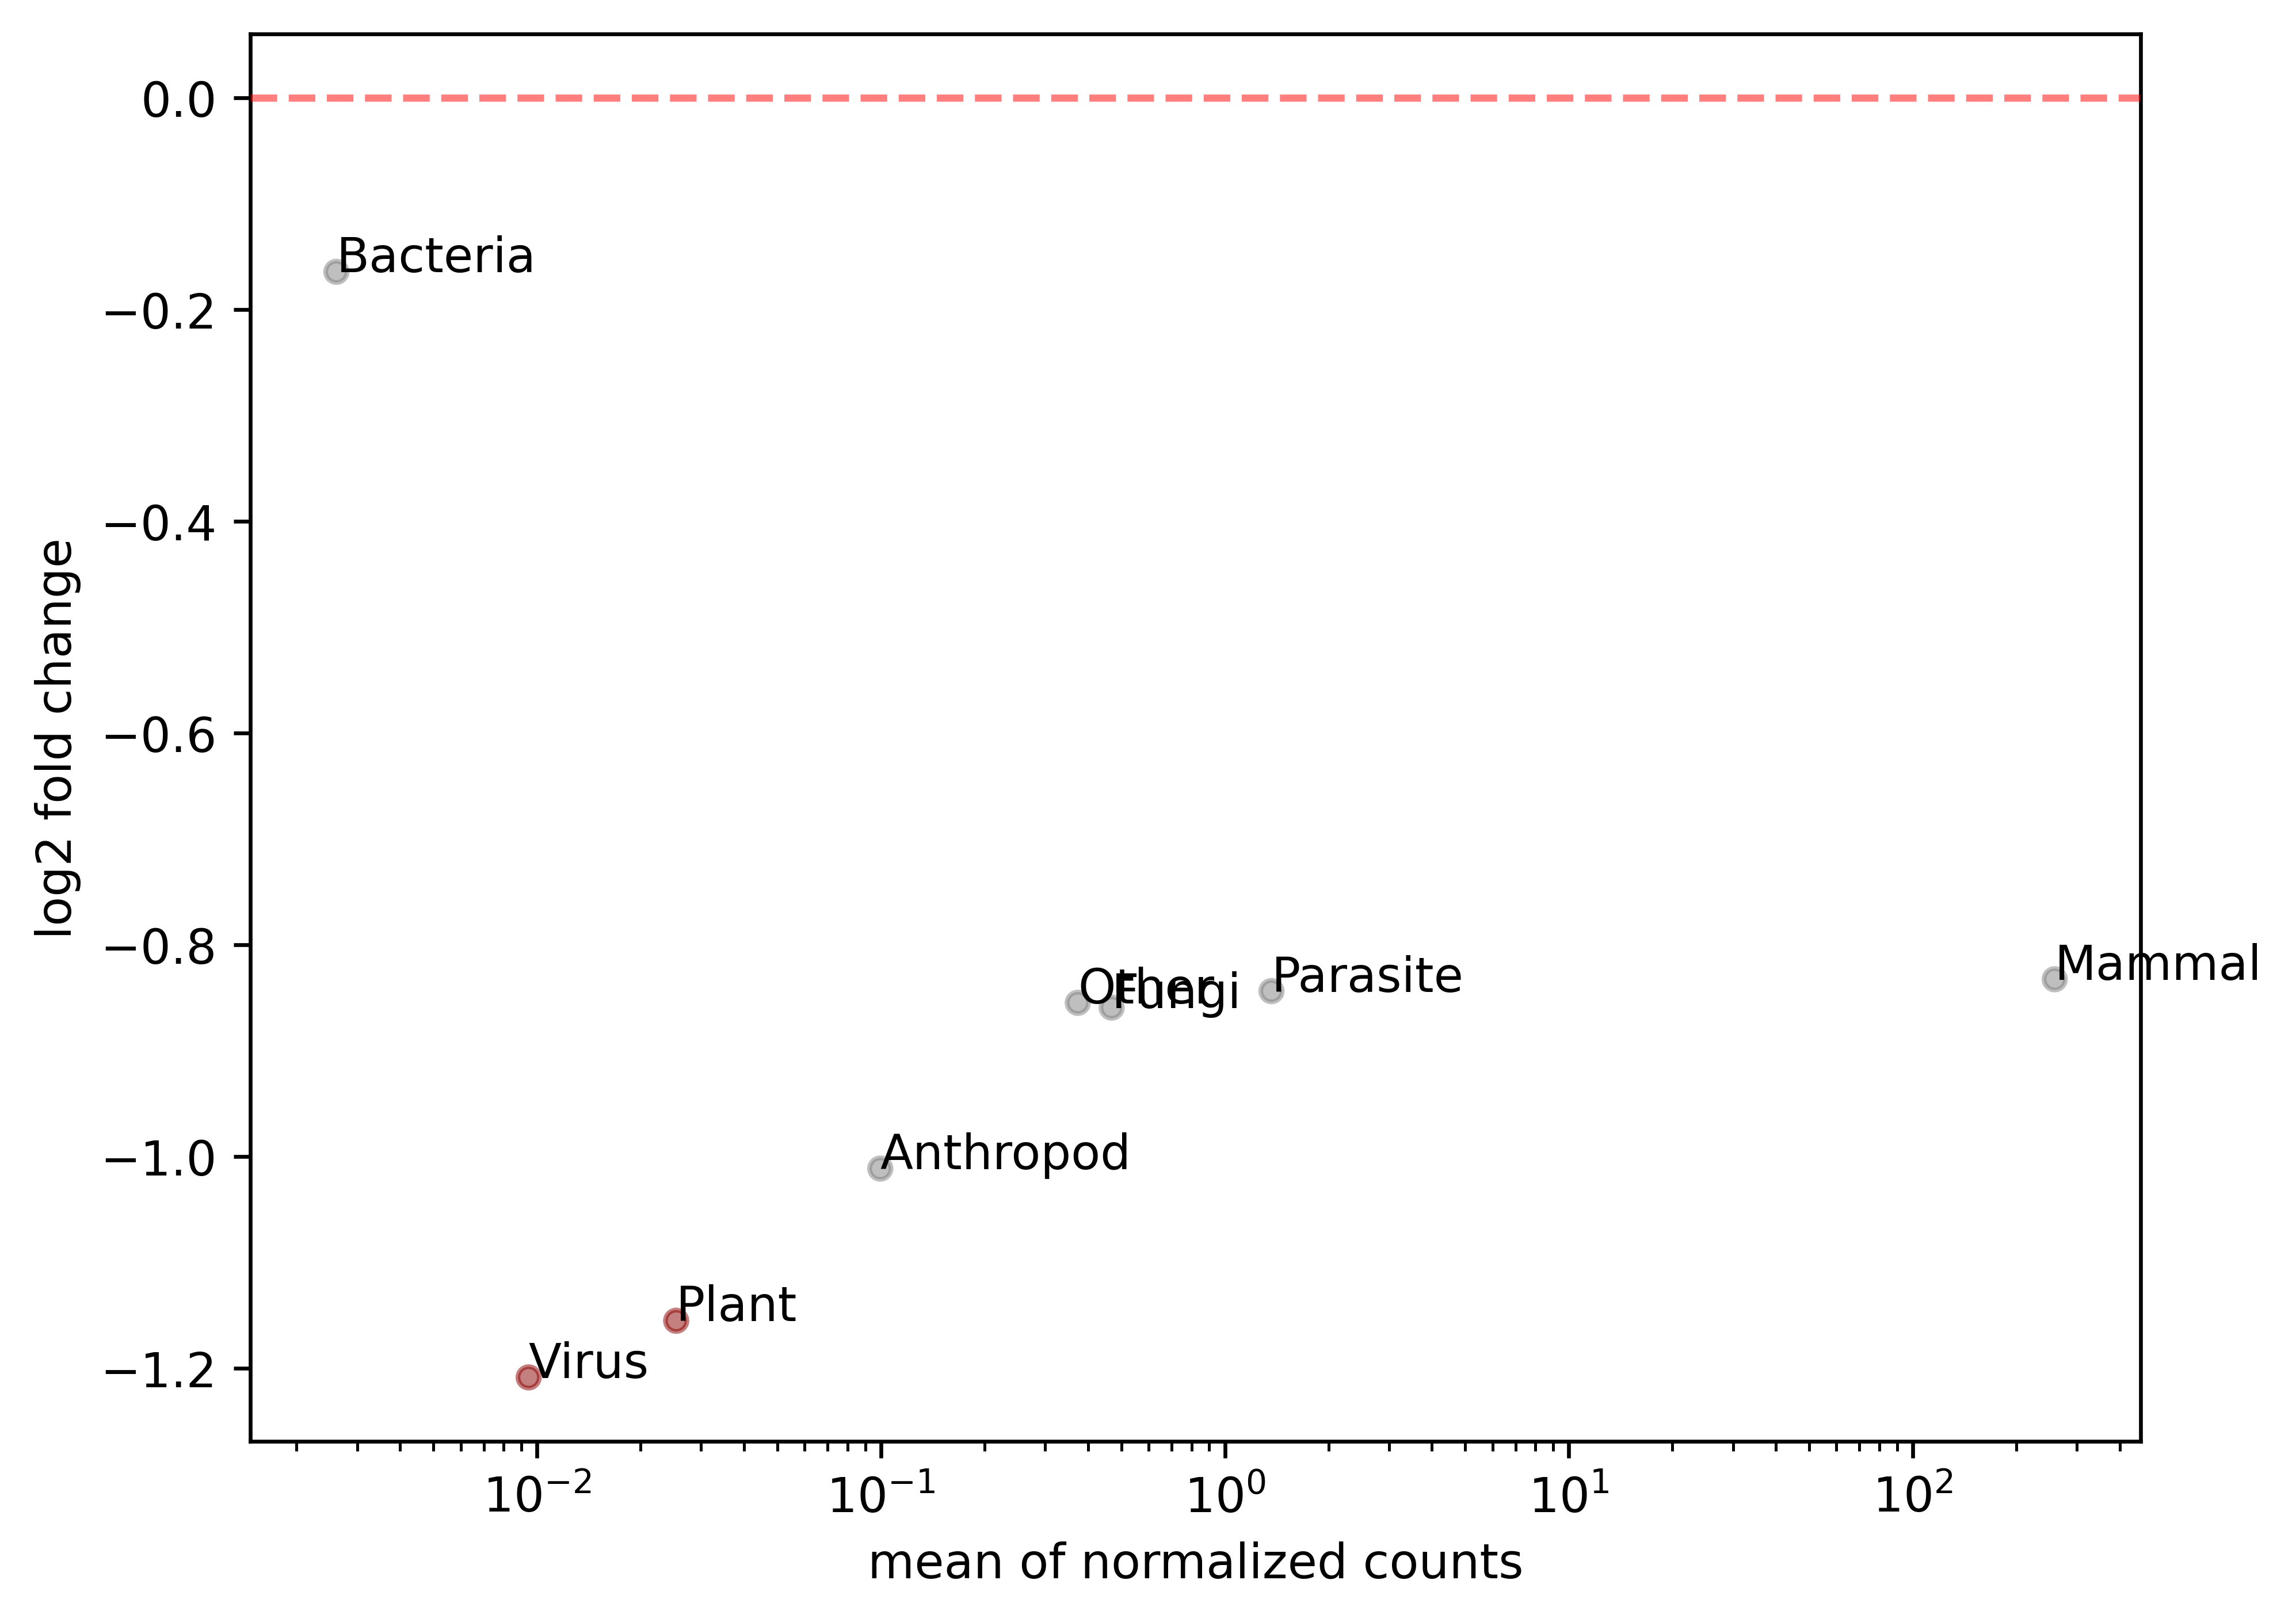

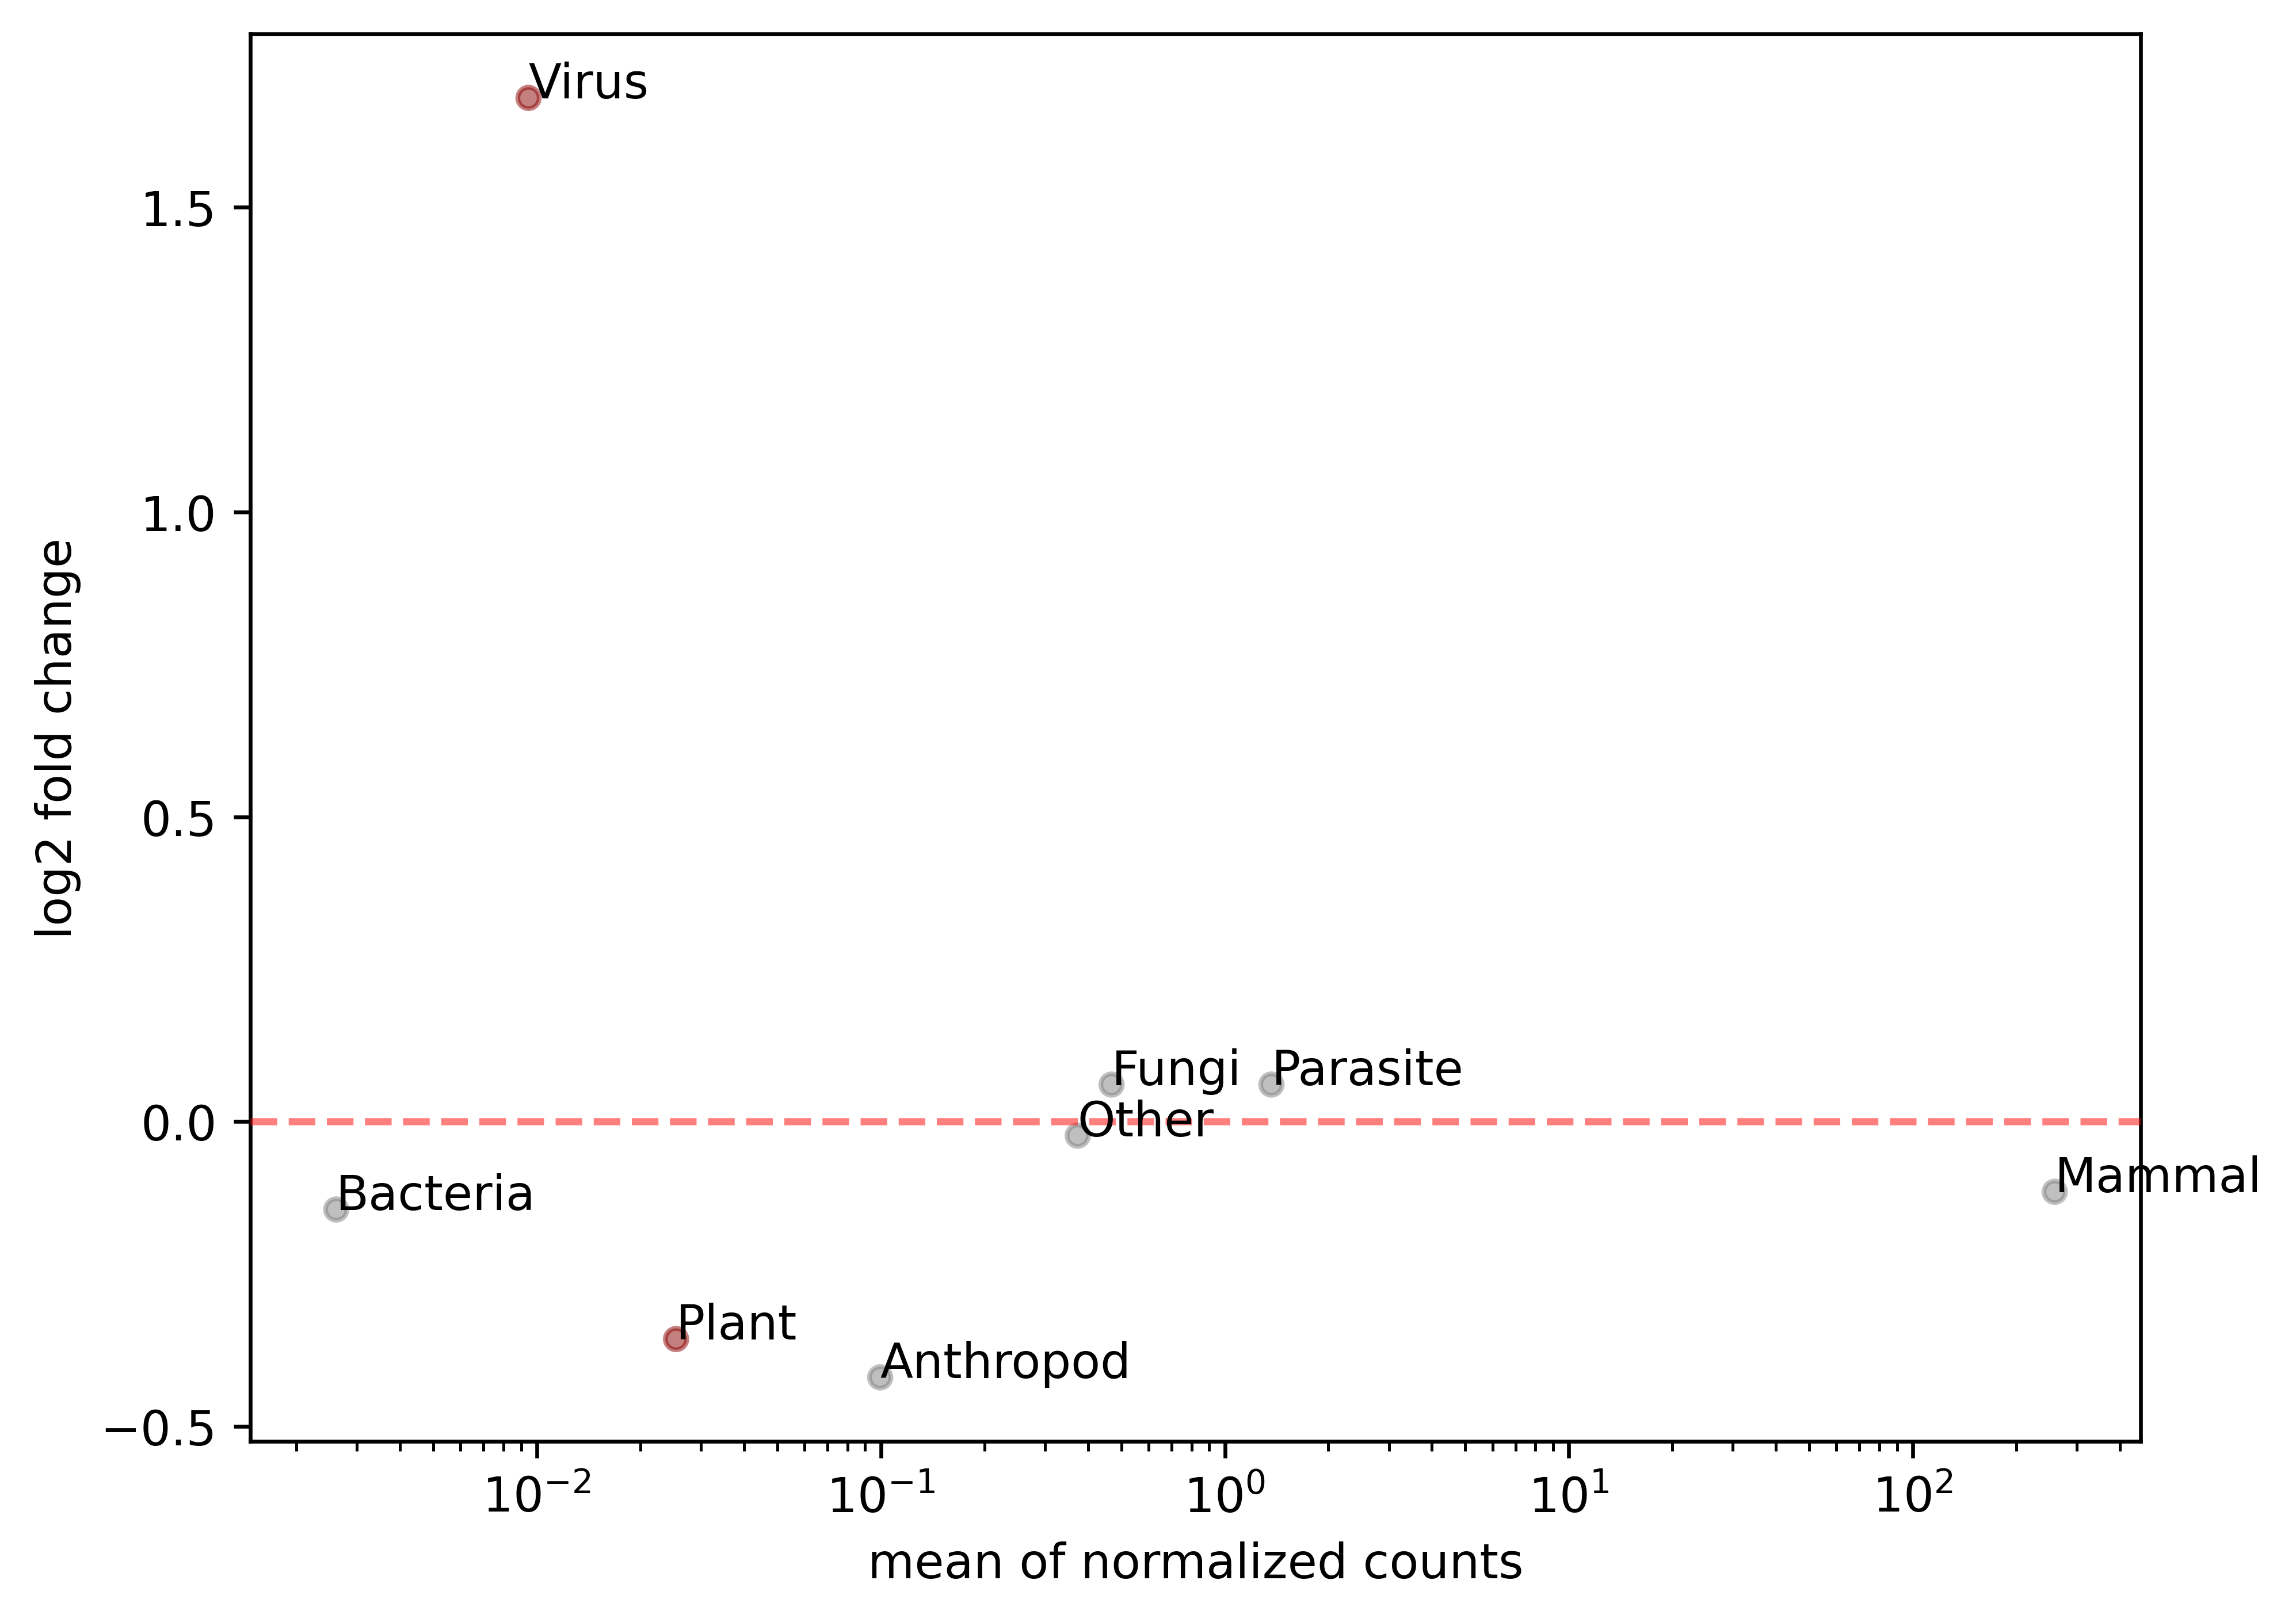

In [90]:
generate_dseq_output(0.8, agg_by='tax_order')

In [159]:
def make_scatter_bar_plot(y, point_labels, ax, agg_by='', name=''):
    w = 0.8
    x = [1, 2, 3, 4]
    colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green']
    edge_colors = ['black', 'black', 'black', 'black']

    ax.set_title(name)

    max_ys = [np.max(yi) for yi in y]
    max_y = np.max(max_ys)

    if max_y > 20:
        ax.set_yscale('log')
    

    y_errs = [np.std(yi) for yi in y]
    ax.bar(x,
        height=[np.mean(yi) for yi in y],
        yerr=y_errs, # error bars
        capsize=12, # error bar cap width in points
        width=w, 
        tick_label=["+ve", "-ve", "total", "random"],
        color=(0,0,0,0),  # face color transparent
        edgecolor=edge_colors,
    )

    for i in range(len(x)):
        # distribute scatter randomly across whole width of bar
        y_vals = y[i]
        x_vals = x[i] + np.random.random(y[i].size) * w - w / 2
        ax.scatter(x_vals, y_vals, color=colors[i], s=10)

        # add label to max point
        # labels = point_labels[i]
        # y_max = np.max(y_vals)
        # for j in range(len(y_vals)):
        #     y_val = y_vals[j]
        #     x_val = x_vals[j]
        #     label = labels[j]
        #     if y_val == y_max:
        #         ax.text(x_val, y_val, label, fontsize=8)
        

In [160]:
def make_panel(threshold, agg_by):
    zoonotic_count_matrix = pd.read_csv(neo4j_data_path + f"{threshold}/" + f"count_matrix_positive_{agg_by}.csv", index_col=0)
    not_zoonotic_count_matrix = pd.read_csv(neo4j_data_path + f"{threshold}/" + f"count_matrix_negative_{agg_by}.csv", index_col=0)
    total_count_matrix = pd.read_csv(neo4j_data_path + f"{threshold}/" + f"count_matrix_total_{agg_by}.csv", index_col=0)
    n = (zoonotic_count_matrix.shape[0] + not_zoonotic_count_matrix.shape[0]) / 2
    random_count_matrix = total_count_matrix.sample(n=int(n), random_state=1)
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    axes = [
        axs[0, 0],
        axs[0, 1],
        axs[0, 2],
        axs[0, 3],
        axs[1, 0],
        axs[1, 1],
        axs[1, 2],
        axs[1, 3],
    ]
    host_classes = [
        'Mammal',
        'Bacteria',
        'Plant',
        'Anthropod',
        'Fungi',
        'Virus',
        'Parasite',
        'Other',
    ]
    if not agg_by:
         fig.suptitle(f"Host distributions for SOTUs using STAT threshold >= {threshold}")
    else:
        fig.suptitle(f"Host distributions of SOTUs normalized by {agg_by} using STAT threshold >= {threshold}")

    for i in range(len(host_classes)):
        host_class = host_classes[i]
        ax = axes[i]
        postive = zoonotic_count_matrix[host_class].loc[zoonotic_count_matrix[host_class] > 0]
        negative = not_zoonotic_count_matrix[host_class].loc[not_zoonotic_count_matrix[host_class] > 0]
        total = total_count_matrix[host_class].loc[total_count_matrix[host_class] > 0]
        random = random_count_matrix[host_class].loc[random_count_matrix[host_class] > 0]
        # postive = zoonotic_count_matrix[host_class]
        # negative = not_zoonotic_count_matrix[host_class]
        # total = total_count_matrix[host_class]
        # random = random_count_matrix[host_class]
        ys = [
            postive,
            negative,
            total,
            random,
        ]
        labels = [
            postive.index.tolist(),
            negative.index.tolist(),
            total.index.tolist(),
            random.index.tolist(),
        ]
        plt.tick_params(
            axis='x',
            which='both',
            bottom=False,
            top=False,      
            # labelbottom=False
        )
        make_scatter_bar_plot(ys, labels, ax, agg_by, host_class)
    
    plt.savefig(neo4j_data_path + f"{threshold}/" + f"host_class_distribution_{agg_by}.png", bbox_inches='tight')


In [ ]:
# find . -name '*diversity*' -exec bash -c 'mv $0 ${0/diversity/tax_order}' {} \;

0.2
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (281, 7)
has_host_order_stat_edges:  (2950, 10)
has_host_metadata_label:  (11558, 8)
sotu_sra_bioproject_counts:  (700, 4)

0.5
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (231, 7)
has_host_order_stat_edges:  (1642, 10)
has_host_metadata_label:  (11558, 8)
sotu_sra_bioproject_counts:  (700, 4)

0.8
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (185, 7)
has_host_order_stat_edges:  (1067, 10)
has_host_metadata_label:  (11558, 8)
sotu_sra_bioproject_counts:  (700, 4)



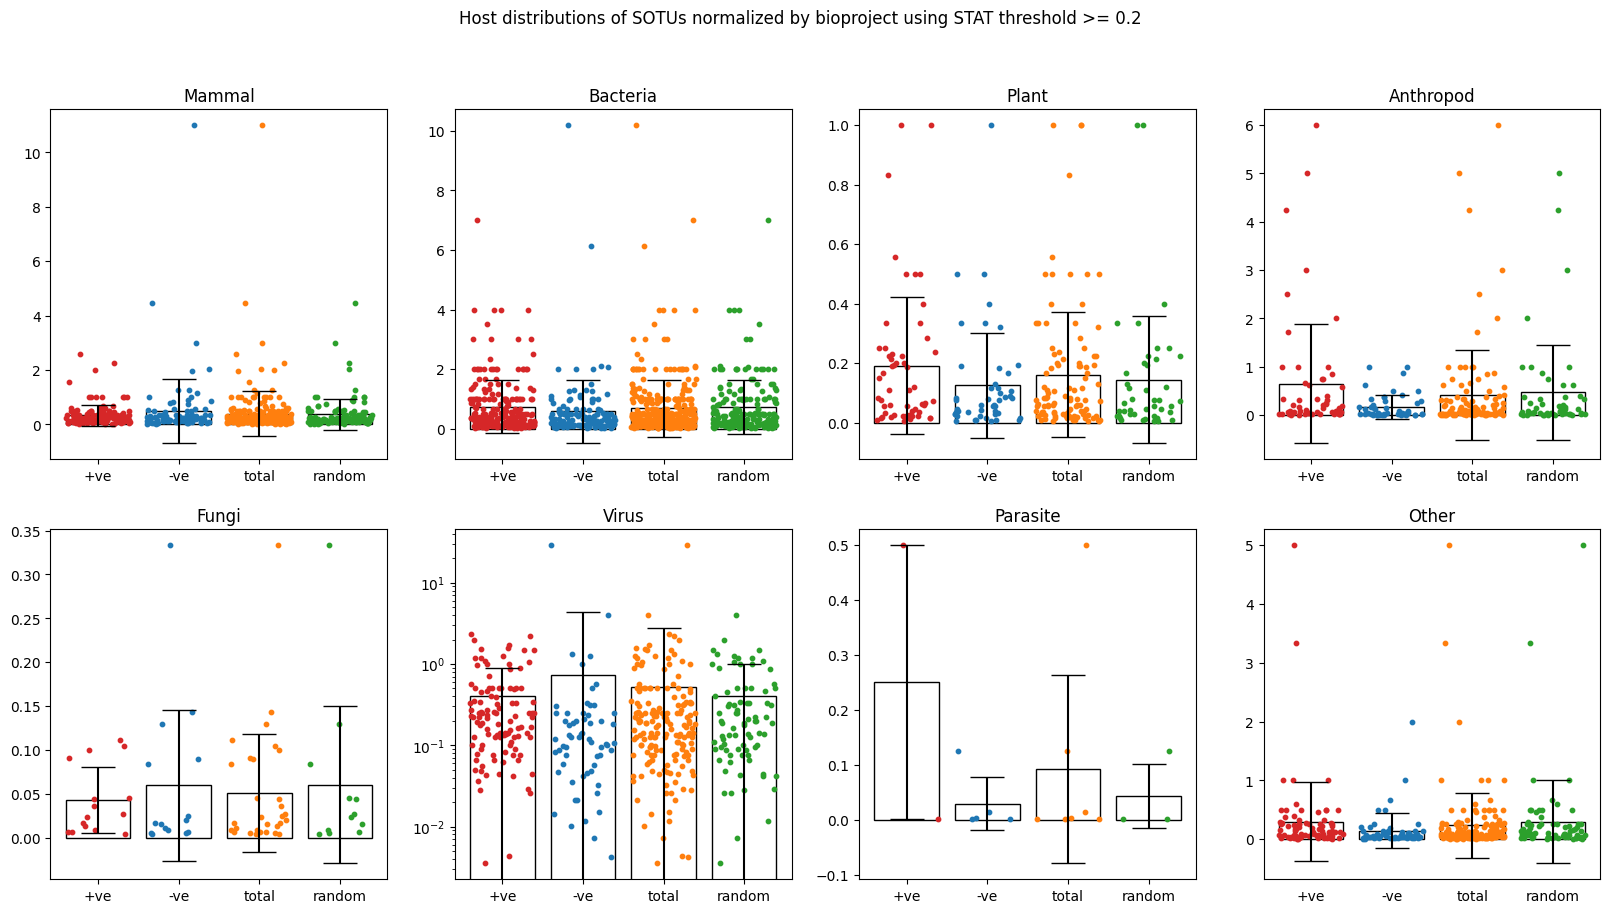

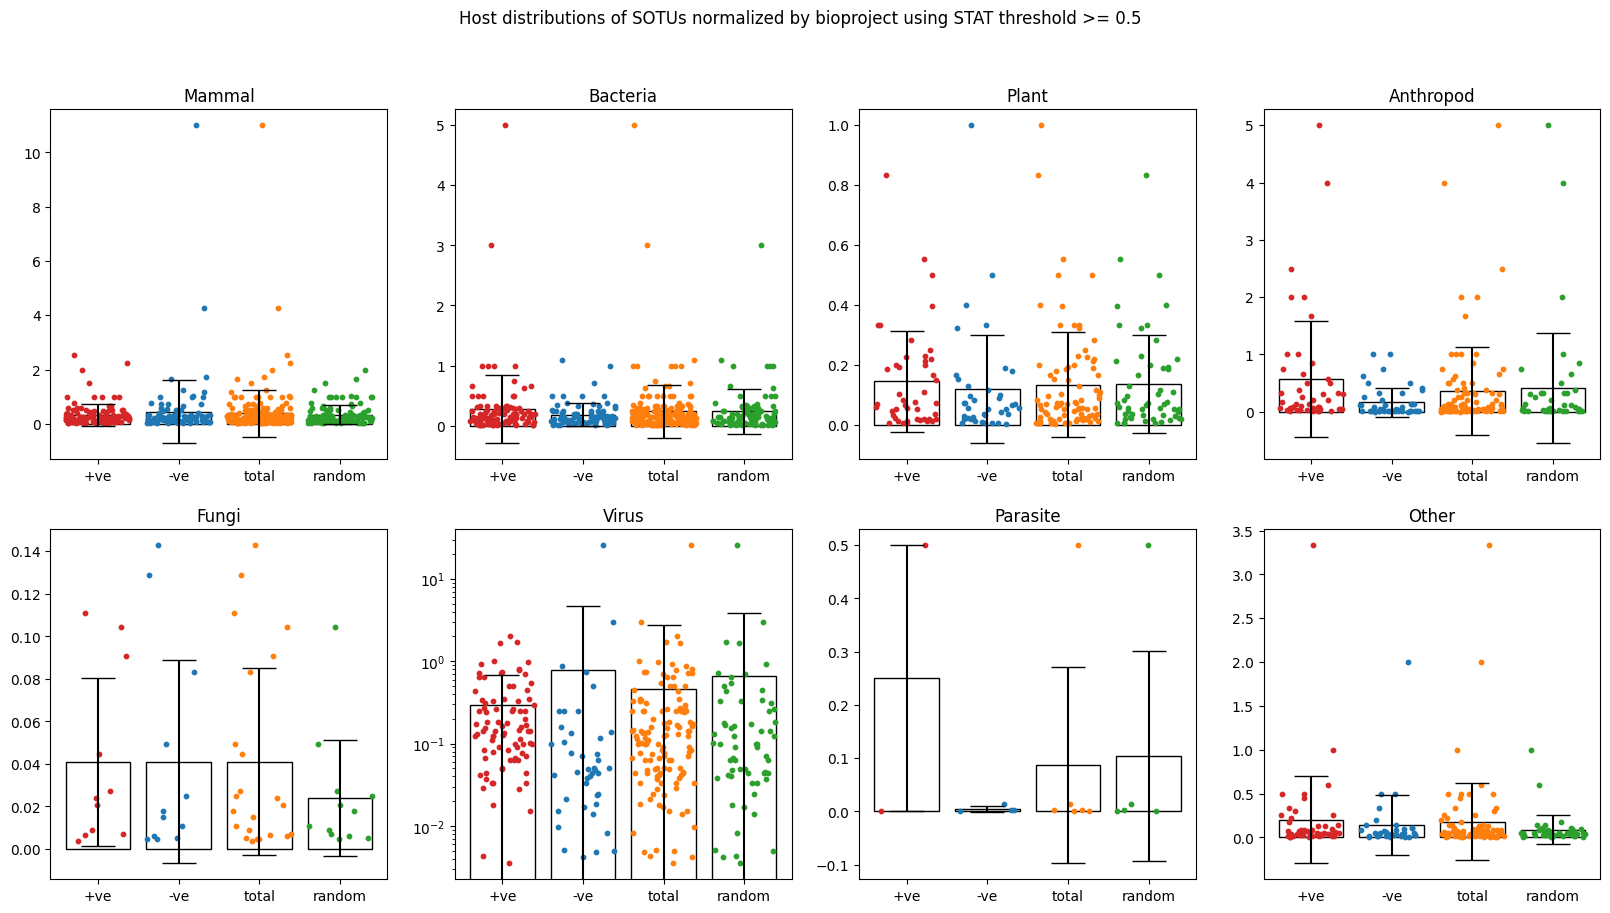

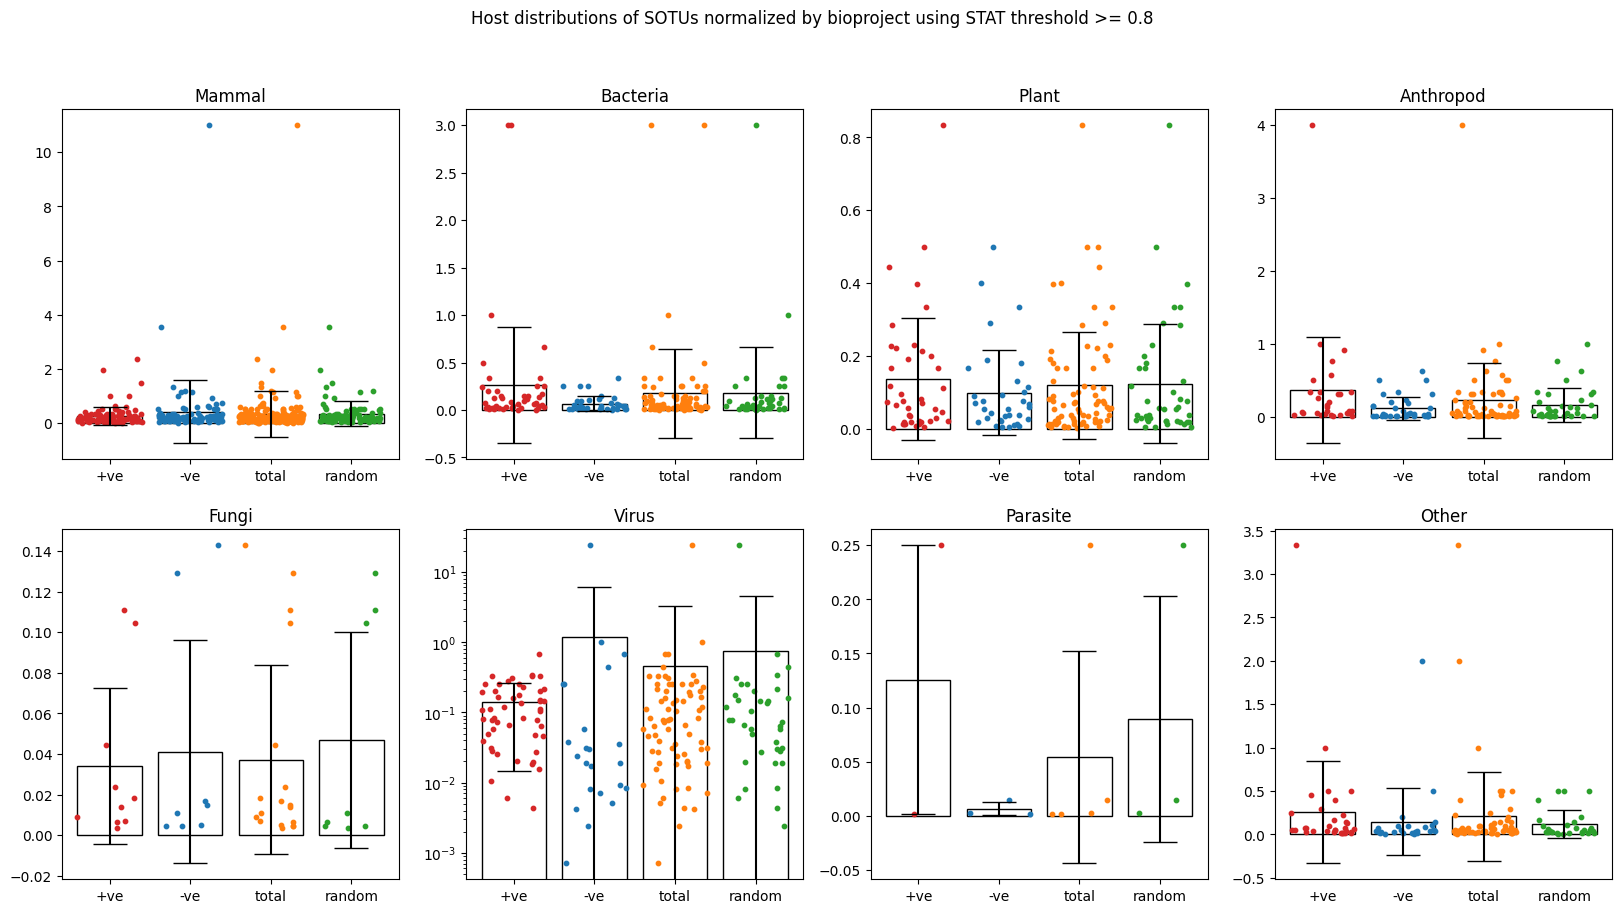

In [163]:
for threshold in stat_thresholds:
    neo4j_data = get_neo4j_data(stat_threshold=threshold)
    generate_count_matricies(neo4j_data, threshold, agg_by='bioproject')
    make_panel(threshold, 'bioproject')


In [91]:
from IPython.display import display, HTML

for threshold in stat_thresholds:
    dseq_stats = pd.read_csv(neo4j_data_path + f"{threshold}/" + f"deseq2_stats_res_diversity.csv", index_col=0)
    display(HTML(dseq_stats.to_html()))


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Anthropod,0.530257,0.038917,0.896911,4.638514,3.509232e-06,5.614771e-06
Bacteria,930.812413,4.088114,0.525975,-1.355739,1.751823e-01,1.751823e-01
Fungi,1.114199,-3.980754,2.391220,2.383149,1.716524e-02,1.961742e-02
Mammal,0.025432,-0.174199,0.172385,7.033175,2.018861e-12,4.037722e-12
Other,0.104512,-0.008258,0.495473,8.137450,4.036917e-16,1.614767e-15
Parasite,0.000351,-0.144270,0.025793,7.167868,7.617459e-13,2.031323e-12
Plant,1.053817,-0.227483,0.932071,4.131841,3.598693e-05,4.798258e-05
Virus,0.025320,0.401129,0.231404,12.461595,1.209271e-35,9.674168e-35


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Anthropod,2.134595,0.006209,0.140280,0.221589,0.824634,0.859343
Bacteria,1886.900682,-0.011158,0.135364,-1.150994,0.249735,0.696837
Fungi,7.524555,-0.005704,0.120538,-0.177210,0.859343,0.859343
Mammal,0.037199,-0.029654,0.106747,0.553655,0.579815,0.859343
Other,4.114969,-0.001433,0.122693,-0.207628,0.835519,0.859343
Parasite,0.000433,-0.144270,0.035005,1.837970,0.066067,0.528535
Plant,3.763107,-0.011193,0.112760,-0.641716,0.521058,0.859343
Virus,0.038715,0.862950,0.350925,1.123291,0.261314,0.696837


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Anthropod,0.099570,-0.419721,0.748000,-1.577311,0.114724,0.267152
Bacteria,0.002611,-0.144270,0.015847,-1.457790,0.144898,0.267152
Fungi,0.468571,0.060662,0.780973,-0.554346,0.579342,0.662105
Mammal,258.585049,-0.115193,0.504614,-1.382005,0.166970,0.267152
Other,0.373516,-0.023136,0.687573,-1.053277,0.292214,0.389618
Parasite,1.365961,0.060722,1.761954,-0.282962,0.777206,0.777206
Plant,0.025395,-0.356877,0.614786,-2.612521,0.008988,0.035951
Virus,0.009457,1.679445,0.651255,-3.577935,0.000346,0.002771


#### ZSEA Result investigation
- original threshold attempted to filter out metagenomics using kmers/total spots
- using kmers/total kmers percentIdentity instead increases majority taxOrder from primates to Bacteroidales (bacteria found in human gut) and Eubacteriales (?)
- likely increases number of metagenomic samples (verify using host labels?)
- u207044 is a majority class, 8973 mammallian, Influenza A virus



The STAT query used above excluded more metagenome runs when the ratio of  (matched kmers / total spots) < 0.2, which artem suggested during previous work on TGaV to seperate 'Mixed' samples.

In this context it seems okay to include them as long as (matched kmers / total kmers) > threshold . Doing so increases number 

### Community detection and node centrality

In [138]:
def construct_gds_projection(neo4j_data):
    graph_name = 'zoonotic'
    nodes = pd.concat([
        neo4j_data['sotu_nodes'][['nodeId', 'labels', 'taxId']],
        neo4j_data['taxon_order_nodes'][['nodeId', 'labels']],
    ])
    relationships = pd.concat([
        neo4j_data['sotu_msa_edges'][['sourceNodeId', 'targetNodeId', 'relationshipType', 'weight']],
        neo4j_data['has_host_order_stat_edges'][['sourceNodeId', 'targetNodeId', 'relationshipType', 'weight']],
    ])

    if gds.graph.exists(graph_name)['exists']:
        gds.graph.drop(gds.graph.get(graph_name))

    G = gds.alpha.graph.construct(
        graph_name=graph_name,
        nodes=nodes,
        relationships=relationships,
        concurrency=4,
        undirected_relationship_types=['HAS_HOST_STAT'],
    )
    return G

In [139]:
def run_community_analysis(G):
  communities = gds.labelPropagation.stream(
    G,
    nodeLabels=['SOTU'],
    relationshipWeightProperty='weight',
    maxIterations=30,
    # seedProperty='taxId',
  )
  unique_communities = communities.communityId.unique()
  community_counter = collections.Counter(communities.communityId)
  print('LPA Unique communities:', len(unique_communities))
  print('LPA Most common communities:', community_counter.most_common(10))

  wcc = gds.wcc.stream(
    G,
    nodeLabels=['SOTU'],
    relationshipWeightProperty='weight',
    threshold=0.5,
    # seedProperty='taxId',
  )
  unique_communities = wcc.componentId.unique()
  community_counter = collections.Counter(wcc.componentId)
  print('WCC Unique communities:', len(unique_communities))
  print('WCC Most common communities:', community_counter.most_common(10))

  page_ranks_sotu = gds.pageRank.stream(
    G,
    nodeLabels=['SOTU'],
    relationshipWeightProperty='weight',
    maxIterations=100,
  )
  page_ranks_sotu = page_ranks_sotu.rename(columns={'score': 'pageRankSotu'})
  page_ranks_sotu['pageRankRound'] = page_ranks_sotu['pageRankSotu'].round(0)

  louvain = gds.louvain.stream(
    G,
    nodeLabels=['SOTU'],
    relationshipWeightProperty='weight',
    # seedProperty='taxId',
  )
  unique_communities = louvain.communityId.unique()
  community_counter = collections.Counter(louvain.communityId)
  print('Louvain Unique communities:', len(unique_communities))
  print('Louvain Most common communities:', community_counter.most_common(10))
  louvain = louvain.rename(columns={'communityId': 'louvainCommunityId'})

  return communities, wcc, page_ranks_sotu, louvain

In [75]:
G = construct_gds_projection(neo4j_data)
communities, wcc, page_ranks_sotu, louvain = run_community_analysis(G)
G.drop()

LPA Unique communities: 438
LPA Most common communities: [(8170199, 45), (7858962, 39), (7743098, 27), (7935516, 20), (7999668, 15), (7971675, 13), (7714332, 12), (8100725, 12), (7994679, 12), (8017721, 10)]
WCC Unique communities: 397
WCC Most common communities: [(431, 86), (2, 42), (0, 40), (5, 23), (34, 17), (41, 15), (1, 14), (106, 14), (649, 12), (674, 11)]


Louvain: 100%|██████████| 100.0/100 [00:00<00:00, 231.77%/s]

Louvain Unique communities: 387
Louvain Most common communities: [(435, 51), (208, 43), (163, 40), (604, 35), (5, 23), (126, 17), (188, 16), (80, 16), (193, 15), (24, 14)]


NameError: name 'modularity' is not defined

Clustering Notes:

- General takeaways:
    - Clustering SOTUs using weight mostly correlates to taxOrder, with some subcommunities within communities. Reovirales doesn't cluster well
    - clustering with SOTU + Hosts creates on very large community and large number of small communities
- 

- SOTU only, default community detection
    - 742 nodes, 2714 edges
    - LPA Unique communities: 438
    - LPA Most common communities: [(8170199, 45), (7858962, 39), (7743098, 27), (7935516, 20), (7999668, 15), (7971675, 13), (7714332, 12), (8100725, 12), (7994679, 12), (8017721, 10)]
    - WCC Unique communities: 386
    - WCC Most common communities: [(431, 86), (2, 43), (0, 40), (5, 23), (34, 17), (48, 16), (79, 16), (41, 15), (1, 14), (106, 14)]
    - Lieden Unique communities: 80
    - Lieden Most common communities: [(145856, 215), (1239574, 49), (11303, 48), (291484, 48), (12637, 46), (11036, 25), (1679172, 24), (28876, 24), (147712, 22), (2593991, 21)]
    - 356 stand alone nodes, 386 remain after hiding stand alone nodes
    - standalone: zoonotic: 245/477, non-zoonotic: 141/265
    - communities are mostly homogenous but contain some other colors (?)
    - non-zoonotic are mixed in med-small communities, have med-small node degree
    - zoonotic make up entire largest connected community
    - 

- SOTU only, seeded community detection
    - 739 nodes, 2570 edges
    - LP Unique communities: 110
    - LP Most common communities: [(145856, 215), (291484, 48), (11277, 47), (1239567, 37), (64300, 27), (28875, 20), (28344, 17), (147711, 17), (40058, 15), (11033, 15)]
    - WCC Unique communities: 98
    - WCC Most common communities: [(145856, 215), (291484, 45), (11072, 43), (11272, 41), (28875, 24), (40050, 23), (1239567, 22), (147711, 19), (1239566, 18), (11020, 16)]
    - Lieden Unique communities: 80
    - Lieden Most common communities: [(145856, 215), (1239574, 49), (11303, 48), (291484, 48), (12637, 46), (11036, 25), (1679172, 24), (28876, 24), (147712, 22), (2593991, 21)]
    - 356 stand alone nodes, 383 remain after hiding stand alone nodes
    - standalone: zoonotic: 242/477, non-zoonotic: 141/265
    - communities are more homogenous than the default
    - taxOrder and taxId corresponds nicely with clusters
    - largest community is even larger
    - overall zoonotic/non-zoonotic appears the same
    - non-zoonotic exist in larger community now
    - low-weight edges seem to involve long-range


- Varying threshold:
    - Varying threshold has little effect on seperating the largest communities and only seems to disconnect small communities
    - No threshold, WCC Unique communities: 98
    - 0.5 threshold, WCC Unique communities: 103
    - 0.75 threshold, WCC Unique communities: 131
    - 0.9 threshold, WCC Unique communities: 177


- Including Hosts
    - creates one very large community, increases number of overall communities
    - LPA Unique communities: 269
    - LPA Most common communities: [(8821550, 588), (7999668, 15), (8100725, 14), (7714332, 12), (8132309, 10), (7707513, 5), (7860156, 5), (7858962, 4), (7721352, 4), (8085484, 3)]
    - WCC Unique communities: 285
    - WCC Most common communities: [(0, 639), (108, 5), (155, 2), (162, 2), (3, 1), (12, 1), (18, 1), (21, 1), (23, 1), (27, 1)]


- Page Rank:
    - Visually seems to be some overlap between pagerank on SOTUs only and zoonotic potential
    - including taxons made overlap less clear since taxon nodes seem to have higher centrality overall

### Node similarity


#### Jaccard index and overlap coeffecient
The input of this algorithm is a bipartite, connected graph containing two disjoint node sets. Each relationship starts from a node in the first node set and ends at a node in the second node set.

The Node Similarity algorithm compares each node that has outgoing relationships with each other such node. For every node n, we collect the outgoing neighborhood N(n) of that node, that is, all nodes m such that there is a relationship from n to m. For each pair n, m, the algorithm computes a similarity for that pair that equals the outcome of the selected similarity metric for N(n) and N(m).


#### Structural equivalence

<!-- https://en.wikipedia.org/wiki/Similarity_(network_science)#Structural_equivalence -->
Two vertices of a network are structurally equivalent if they share many of the same neighbors.


In [62]:
def construct_gds_projection_similarity(neo4j_data):
    graph_name = 'zoonotic'
    zoonotic_sotu = neo4j_data['sotu_nodes'].loc[neo4j_data['sotu_nodes']['isZoonotic'] == True]
    zoonotic_sotu['labels'] = "['Palmprint', 'SOTU', 'Zoonotic']"

    not_zoonotic_sotu = neo4j_data['sotu_nodes'].loc[neo4j_data['sotu_nodes']['isZoonotic'] == False]
    not_zoonotic_sotu['labels'] = "['Palmprint', 'SOTU', 'NotZoonotic']"

    nodes = pd.concat([
        zoonotic_sotu[['nodeId', 'labels', 'taxId']],
        not_zoonotic_sotu[['nodeId', 'labels', 'taxId']],
        neo4j_data['taxon_order_nodes'][['nodeId', 'labels']],
    ])
    relationships = pd.concat([
        neo4j_data['sotu_msa_edges'][['sourceNodeId', 'targetNodeId', 'relationshipType', 'weight']],
        neo4j_data['has_host_order_stat_edges'][['sourceNodeId', 'targetNodeId', 'relationshipType', 'weight']],
    ])

    if gds.graph.exists(graph_name)['exists']:
        gds.graph.drop(gds.graph.get(graph_name))

    G = gds.alpha.graph.construct(
        graph_name=graph_name,
        nodes=nodes,
        relationships=relationships,
        concurrency=4,
        undirected_relationship_types=['HAS_HOST_STAT'],
    )
    return G

In [89]:
def run_similarity_analysis(G):
  similarity = gds.nodeSimilarity.filtered.stats(
    G,
    # nodeLabels=['SOTU', 'Taxon'],
    relationshipWeightProperty='weight',
    sourceNodeFilter="['Palmprint', 'SOTU', 'Zoonotic']",
    targetNodeFilter="['Palmprint', 'SOTU', 'NotZoonotic']",
    similarityMetric='overlap',
  )
  return similarity

In [90]:
neo4j_data = get_neo4j_data(stat_threshold=0.8)
G = construct_gds_projection_similarity(neo4j_data)
similarity = run_similarity_analysis(G)
G.drop()

0.8
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (185, 7)
has_host_order_stat_edges:  (1067, 10)
has_host_metadata_label:  (11558, 8)
sotu_sra_bioproject_counts:  (700, 4)



/var/folders/vl/wsxpm_412lgcfm03dqd31qmh0000gn/T/ipykernel_13440/3323682487.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoonotic_sotu['labels'] = "['Palmprint', 'SOTU', 'Zoonotic']"
/var/folders/vl/wsxpm_412lgcfm03dqd31qmh0000gn/T/ipykernel_13440/3323682487.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_zoonotic_sotu['labels'] = "['Palmprint', 'SOTU', 'NotZoonotic']"


preProcessingMillis                                                       0
computeMillis                                                             9
postProcessingMillis                                                      6
nodesCompared                                                           277
similarityPairs                                                        1590
similarityDistribution    {'p1': 0.048001885414123535, 'p5': 0.109730601...
configuration             {'topK': 10, 'similarityMetric': 'OVERLAP', 'b...
Name: 0, dtype: object


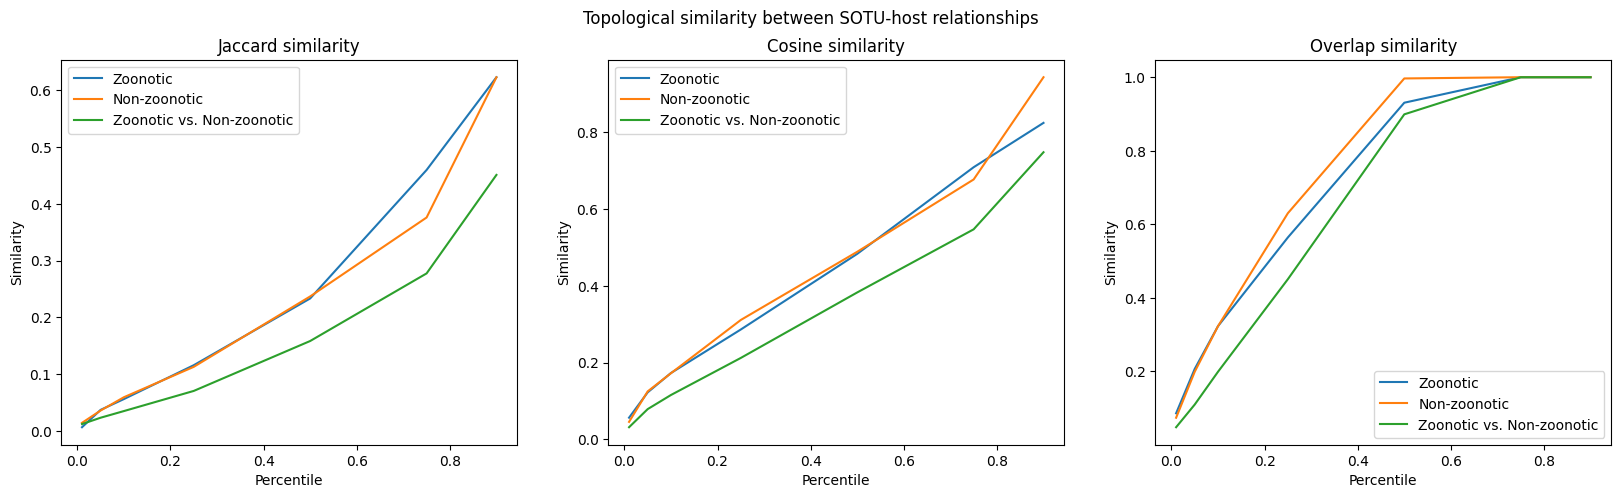

In [99]:
# Plot stat percentiles
def plot_percentiles(percentiles, label, ax):
    xs = np.array([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9])
    ys = np.array([
        percentiles['p1'], 
        percentiles['p5'], 
        percentiles['p10'], 
        percentiles['p25'], 
        percentiles['p50'], 
        percentiles['p75'],
        percentiles['p90']
    ])
    ax.plot(xs, ys, label=label)

def make_similarity_plot(plot_data, ax, metric):
    for percentiles, label in plot_data:
        plot_percentiles(percentiles, label, ax)
        ax.set_title(f"{metric} similarity")
        ax.legend()
        ax.set_xlabel('Percentile')
        ax.set_ylabel(f'Similarity')
        # ax.show()


fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(f"Topological similarity between SOTU-host relationships")

p_jaccard_similarity = {
    'p1': 0.006226286292076111, 
    'p5': 0.03683541715145111, 
    'max': 0.9996871799230576, 
    'p90': 0.6231613010168076, 
    'p50': 0.233213409781456, 
    'p95': 0.7315406650304794, 
    'p10': 0.05585525929927826, 
    'p75': 0.45966337621212006, 
    'p99': 0.9601096957921982, 
    'p100': 0.9996871799230576, 
    'p25': 0.11555241048336029, 
    'min': 0.0021107345819473267, 
    'mean': 0.29964364775062835, 
    'stdDev': 0.22793904866475345
}

n_jaccard_similarity = {
    'p1': 0.013945013284683228, 
    'p5': 0.035666435956954956, 
    'max': 0.9985389411449432, 
    'p90': 0.6230315864086151, 
    'p50': 0.23678013682365417, 
    'p95': 0.760768860578537, 
    'p10': 0.05910870432853699, 
    'p75': 0.375881165266037, 
    'p99': 0.9635772407054901, 
    'p100': 0.9985389411449432, 
    'p25': 0.1126541793346405, 
    'min': 0.005196064710617065, 
    'mean': 0.2851334099903054, 
    'stdDev': 0.22294227675603484
}

p_n_jaccard_similarity = {
    'p1': 0.011814743280410767, 
    'p5': 0.02298399806022644, 
    'max': 0.996669739484787, 
    'p90': 0.4509677588939667, 
    'p50': 0.158199280500412, 
    'p95': 0.6104812324047089, 
    'p10': 0.03470847010612488, 
    'p75': 0.27733609080314636, 
    'p99': 0.9284133613109589, 
    'p100': 0.996669739484787, 
    'p25': 0.07020518183708191, 
    'min': 0.0050831139087677, 
    'mean': 0.20835609805284055, 
    'stdDev': 0.18820419924207862
}


jaccard_plot_data = [
    (p_jaccard_similarity, 'Zoonotic'),
    (n_jaccard_similarity, 'Non-zoonotic'),
    (p_n_jaccard_similarity, 'Zoonotic vs. Non-zoonotic'),
]


p_cosine_similarity = {
    'p1': 0.05653637647628784,
    'p5': 0.12252134084701538,
    'max': 1.0000075697898865,
    'p90': 0.8245849013328552,
    'p50': 0.4833793044090271,
    'p95': 1.0000075697898865,
    'p10': 0.17297357320785522,
    'p75': 0.7090529799461365,
    'p99': 1.0000075697898865,
    'p100': 1.0000075697898865,
    'p25': 0.2862948775291443,
    'min': 0.01009821891784668,
    'mean': 0.49937089322768535,
    'stdDev': 0.25360408824120867
}

n_cosine_similarity = {
    'p1': 0.045622289180755615,
    'p5': 0.12502187490463257,
    'max': 1.0000075697898865,
    'p90': 0.9435271620750427,
    'p50': 0.488761842250824,
    'p95': 1.0000075697898865,
    'p10': 0.17241567373275757,
    'p75': 0.6771621108055115,
    'p99': 1.0000075697898865,
    'p100': 1.0000075697898865,
    'p25': 0.31114381551742554,
    'min': 0.015101730823516846,
    'mean': 0.5122986226223548,
    'stdDev': 0.2618824125787298
 }

p_n_cosine_similarity = {
    'p1': 0.031713902950286865,
    'p5': 0.0788993239402771,
    'max': 1.0000075697898865,
    'p90': 0.7481231093406677,
    'p50': 0.3828715682029724,
    'p95': 1.0000075697898865,
    'p10': 0.11567872762680054,
    'p75': 0.5472487807273865,
    'p99': 1.0000075697898865,
    'p100': 1.0000075697898865,
    'p25': 0.2122287154197693,
    'min': 0.012007713317871094,
    'mean': 0.41080326880299073,
    'stdDev': 0.2504437670687134,
}

cosine_plot_data = [
    (p_cosine_similarity, 'Zoonotic'),
    (n_cosine_similarity, 'Non-zoonotic'),
    (p_n_cosine_similarity, 'Zoonotic vs. Non-zoonotic'),
]

p_overlap_similarity = {
    'p1': 0.08582377433776855,
    'p5': 0.20670676231384277,
    'max': 1.0000073909759521,
    'p90': 1.0000073909759521,
    'p50': 0.9306600093841553,
    'p95': 1.0000073909759521,
    'p10': 0.3230149745941162,
    'p75': 1.0000073909759521,
    'p99': 1.0000073909759521,
    'p100': 1.0000073909759521,
    'p25': 0.5642354488372803,
    'min': 0.036835432052612305,
    'mean': 0.7865739040768024,
    'stdDev': 0.2753602414352061
 }

n_overlap_similarity =  {
    'p1': 0.07382142543792725,
    'p5': 0.19894587993621826,
    'max': 1.0000075101852417,
    'p90': 1.0000075101852417,
    'p50': 0.9966849088668823,
    'p95': 1.0000075101852417,
    'p10': 0.32293689250946045,
    'p75': 1.0000075101852417,
    'p99': 1.0000075101852417,
    'p100': 1.0000075101852417,
    'p25': 0.6301649808883667,
    'min': 0.018406987190246582,
    'mean': 0.8068429944263134,
    'stdDev': 0.2764165272635806
}

p_n_overlap_similarity = {
    'p1': 0.048001885414123535,
    'p5': 0.10973060131072998,
    'max': 1.0000075101852417,
    'p90': 1.0000075101852417,
    'p50': 0.8990782499313354,
    'p95': 1.0000075101852417,
    'p10': 0.19894587993621826,
    'p75': 1.0000075101852417,
    'p99': 1.0000075101852417,
    'p100': 1.0000075101852417,
    'p25': 0.4506796598434448,
    'min': 0.018689990043640137,
    'mean': 0.715828363175662,
    'stdDev': 0.32321866026536694
}

overlap_plot_data = [
    (p_overlap_similarity, 'Zoonotic'),
    (n_overlap_similarity, 'Non-zoonotic'),
    (p_n_overlap_similarity, 'Zoonotic vs. Non-zoonotic'),
]
make_similarity_plot(jaccard_plot_data, ax[0], 'Jaccard')
make_similarity_plot(cosine_plot_data, ax[1], 'Cosine')
make_similarity_plot(overlap_plot_data, ax[2], 'Overlap')


### Graphistry visualizations

In [150]:
# Create node and relationship dataframes with full information
def get_graphistry_df(
        neo4j_data, communities, page_ranks_sotu, louvain
    ):

    neo4j_data['sotu_nodes']['displayLabel'] = ''
    neo4j_data['taxon_order_nodes']['displayLabel'] = neo4j_data['taxon_order_nodes']['taxOrder']
    neo4j_data['sotu_nodes']['type'] = 'SOTU'
    neo4j_data['taxon_order_nodes']['type'] = 'Taxon'

    nodes = pd.concat([
        neo4j_data['sotu_nodes'],
        neo4j_data['taxon_order_nodes'],
    ])
    nodes = nodes.merge(
        communities,
        left_on='nodeId',
        right_on='nodeId',
        how='left',
    )
    nodes = nodes.merge(
        page_ranks_sotu,
        left_on='nodeId',
        right_on='nodeId',
        how='left',
    )
    nodes = nodes.merge(
        louvain,
        left_on='nodeId',
        right_on='nodeId',
        how='left',
    )

    nodes = nodes[[
        'appId', 'labels', 'type',
        'taxId', 'isZoonotic', 'hostClass',
        'taxRank', 'communityId',
        'taxOrder', 'displayLabel',
        'pageRankSotu', 'louvainCommunityId',
    ]].astype(str)

    # Encode zoonotic status to use default color pallette
    nodes['zoonoticColorCodes'] = nodes['isZoonotic'].replace({'True': 1, 'False': 0, 'nan': 2 })
    nodes['zoonoticColorCodes'] = nodes['zoonoticColorCodes'].astype('int32')


    # Encode communityId to use default color pallette
    nodes['communityId'] = nodes['communityId'].astype('float64')
    nodes['communityId'] = nodes['communityId'].fillna(-1)
    nodes['communityId'] = nodes['communityId'].astype('int32')
    labels = nodes['communityId'].unique()
    mapping = {label: i for i, label in enumerate(labels)}
    nodes['communityId'] =  nodes['communityId'].replace(mapping)
    nodes['communityColorCodes'] = nodes['communityId'].mod(11)


    # Add host counts for palmprints
    stat_hosts_excl_mixed = neo4j_data['has_host_order_stat_edges'][neo4j_data['has_host_order_stat_edges']['targetAppId'] != 12908]
    host_counts = stat_hosts_excl_mixed.groupby('sourceAppId').size().groupby(level=0).max()
    # host_counts = neo4j_data['has_host_order_stat_edges'].groupby('sourceAppId').size().groupby(level=0).max()
    host_counts = host_counts.reset_index()
    host_counts = host_counts.rename({0: 'hostCount'}, axis='columns')
    host_counts['hostCountNormalized'] = round((host_counts['hostCount'] / host_counts['hostCount'].max()) * 100, -1).astype('int32')
    nodes = nodes.merge(
        host_counts,
        left_on='appId',
        right_on='sourceAppId',
        how='left',
    )

    relationships = pd.concat([
        neo4j_data['sotu_msa_edges'],
        neo4j_data['has_host_order_stat_edges'],
    ])
    
    relationships['targetAppId'] = relationships['targetAppId'].astype(str)
    relationships['sourceAppId'] = relationships['sourceAppId'].astype(str)

    relationships['weight'] = relationships['weight'].astype(float)
    relationships['weightInt'] = round(relationships['weight'] * 100, -1).astype('int32')
    relationships = relationships[[
        'sourceAppId', 'targetAppId', 'relationshipType', 
        'weight', 'weightInt',
    ]].astype(str)
    relationships['weightInt'] = relationships['weightInt'].astype('int32')
    return nodes, relationships



def load_or_create_graphistry_df(stat_threshold, node_filename, relationship_filename, use_cache=False):
    if use_cache and os.path.exists(graphistry_data_path + node_filename) \
            and os.path.exists(graphistry_data_path + relationship_filename):
        nodes = pd.read_csv(graphistry_data_path + node_filename)
        edges = pd.read_csv(graphistry_data_path + relationship_filename)
    else:
        neo4j_data = get_neo4j_data(stat_threshold)
        G = construct_gds_projection(neo4j_data)
        communities, wcc, page_ranks_sotu, louvain = run_community_analysis(G)
        # binary_pvals, multi_pvals = run_pval_analysis(neo4j_data)
        nodes, edges = get_graphistry_df(
            neo4j_data, communities, page_ranks_sotu, louvain
        )
        nodes.to_csv(graphistry_data_path + node_filename, index=False)
        edges.to_csv(graphistry_data_path + relationship_filename, index=False)
    return nodes, edges


In [151]:
stat_threshold = 0.8
nodes, relationships = load_or_create_graphistry_df(stat_threshold, 'nodes.csv', 'edges.csv', False)
# nodes, relationships = load_or_create_graphistry_df('nodes_v2.csv', 'edges_v2.csv')

0.8
sotu_nodes:  (742, 8)
sotu_msa_edges:  (2714, 7)
taxon_order_nodes:  (185, 7)
has_host_order_stat_edges:  (1067, 10)
has_host_metadata_label:  (11558, 8)
sotu_sra_bioproject_counts:  (700, 4)

LPA Unique communities: 438
LPA Most common communities: [(8170199, 45), (7858962, 39), (7743098, 27), (7935516, 20), (7999668, 15), (7971675, 13), (7714332, 12), (8100725, 12), (7994679, 12), (8017721, 10)]
WCC Unique communities: 397
WCC Most common communities: [(431, 86), (2, 42), (0, 40), (5, 23), (34, 17), (41, 15), (1, 14), (106, 14), (649, 12), (674, 11)]
Louvain Unique communities: 387
Louvain Most common communities: [(435, 51), (208, 43), (163, 40), (604, 35), (5, 23), (126, 17), (188, 16), (80, 16), (193, 15), (24, 14)]


In [145]:
alt_color_pallete = [
    "rgb(166, 206, 227)",
    "rgb(31, 120, 180)",
    "rgb(178, 223, 138)",
    "rgb(51, 160, 44)",
    "rgb(251, 154, 153)",
    "rgb(227, 26, 28)",
    "rgb(253, 191, 111)",
    "rgb(255, 127, 0)",
    "rgb(202, 178, 214)",
    "rgb(106, 61, 154)",
    "rgb(255, 255, 153)", 
    "#ffffff",
]

categorical_colors = {}

for communityId in nodes.communityColorCodes.unique():
    categorical_colors[str(communityId)] = alt_color_pallete[communityId % len(alt_color_pallete)]

categorical_colors[11] = "#808080"

# for i, row in nodes.iterrows():
#     if row['hostCount'] > 1:
#         nodes.at[i,'communityColorCodes'] = 11

In [155]:
g = graphistry.bind()

g = g.bind(
    source='sourceAppId',
    destination='targetAppId',
    edge_weight='weight',
).edges(relationships)

g = g.bind(
    node='appId',
    point_label='displayLabel',
    point_size=None,
    # point_size='statCoverageInt',
).nodes(nodes)


params = {
        'play': 2000,
        'menu': True, 
        'info': True,
        'showArrows': True,
        'pointSize': 2.0, 
        # 'edgeCurvature': 0.5,
        'edgeOpacity': 0.25, 
        'pointOpacity': 1.0,
        # 'lockedX': False, 'lockedY': False, 'lockedR': False,
        'linLog': True, 
        'compactLayout': True,
        'strongGravity': True,
        'dissuadeHubs': False,
        'edgeInfluence': 5,
        # 'precisionVsSpeed': 0, 'gravity': 1.0, 'scalingRatio': 1.0,
        # 'showLabels': True, 'showLabelOnHover': True,
        # 'showPointsOfInterest': True, 'showPointsOfInterestLabel': True, 
        'showLabelPropertiesOnHover': True,
        'pointsOfInterestMax': 10,
      }

g = g.settings(url_params=params)


g = g.addStyle(
    bg={
        'color': 'black',
})

# g = g.encode_point_color(
#     'communityColorCodes',
#     categorical_mapping=categorical_colors,
# )


g = g.encode_point_color(
    'zoonoticColorCodes',
    categorical_mapping={0: 'rgb(10, 228, 108)', 1: 'rgb(228, 108, 10)', 2: 'rgb(108, 10, 228)'},
)

g.plot()

In [ ]:
print(urllib.parse.urlencode(params))

-